# Movielens

In [2]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
np.random.seed(42)

In [4]:
def timepoint_split(data, time_split_q=0.95):
    """
    Split data into training, testset, and holdout datasets based on a timepoint split
    and according to the `warm-start` evaluation strategy.
    """
    timepoint = data.timestamp.quantile(q=time_split_q, interpolation='nearest')
    test_ = data.query('timestamp >= @timepoint')
    rest_ = data.drop(test_.index)

    holdout_ = (
        test_
        .sort_values('timestamp')
        .drop_duplicates(subset=['userid'], keep='first')
    )

    training = rest_.query('userid not in @holdout_.userid')
    train_items = training.movieid.unique()

    testset_ = rest_.query('userid in @holdout_.userid and movieid in @train_items')
    test_users = testset_.userid.unique()

    holdout = (
        holdout_
        .query('userid in @test_users and movieid in @train_items')
        .sort_values('userid')
    )

    testset = (
        testset_
        .query('userid in @holdout.userid')
        .sort_values('userid')
    )

    return training, testset, holdout

In [5]:
from polara import get_movielens_data


data, genres_info = get_movielens_data(
    get_genres=True, 
    split_genres=False,
    include_time=True
)
rename_map = {}
if "userid" in data.columns: rename_map["userid"] = "userid"
if "movieid" in data.columns: rename_map["movieid"] = "movieid"
ratings = data.rename(columns=rename_map)

required = {"userid", "movieid", "rating", "timestamp"}
missing = required - set(ratings.columns)
if missing:
    raise ValueError(f"MovieLens dataframe missing required columns: {missing}. Columns: {ratings.columns.tolist()}")

ratings["userid"] = pd.to_numeric(ratings["userid"], errors="raise").astype(np.int64)
ratings["movieid"] = pd.to_numeric(ratings["movieid"], errors="raise").astype(np.int64)
ratings["timestamp"] = pd.to_numeric(ratings["timestamp"], errors="raise").astype(np.int64)
ratings["rating"] = pd.to_numeric(ratings["rating"], errors="raise").astype(np.float32)

print("Loaded:", ratings.shape, "users:", ratings.userid.nunique(), "items:", ratings.movieid.nunique())


Loaded: (1000209, 4) users: 6040 items: 3706


In [6]:
train, test, holdout = timepoint_split(ratings, time_split_q=0.95)

print("Rows:", {"train": len(train), "test": len(test), "holdout": len(holdout)})
print("Users:", {"train": train.userid.nunique(), "test": test.userid.nunique(), "holdout": holdout.userid.nunique()})
print("Items:", {"train": train.movieid.nunique(), "test": test.movieid.nunique(), "holdout": holdout.movieid.nunique()})
train_items = set(train.movieid.unique())


Rows: {'train': 725370, 'test': 221697, 'holdout': 802}
Users: {'train': 5227, 'test': 802, 'holdout': 802}
Items: {'train': 3652, 'test': 3423, 'holdout': 488}


In [ ]:
train_users = train.userid.unique()
train_items_arr = train.movieid.unique()

user2row = {u: i for i, u in enumerate(train_users)}
item2col = {m: j for j, m in enumerate(train_items_arr)}

train_rows = train.userid.map(user2row).to_numpy()
train_cols = train.movieid.map(item2col).to_numpy()
train_vals = train.rating.to_numpy(dtype=np.float32)

R_train = csr_matrix(
    (train_vals, (train_rows, train_cols)),
    shape=(len(train_users), len(train_items_arr)),
    dtype=np.float32
)

print("R_train:", R_train.shape, "nnz:", R_train.nnz)

R_train: (5227, 3652) nnz: 725370


In [9]:
def iALS(ratings, rank, weight_f = lambda x: x, iters = 100, l2 = 1):
    t = time.time()
    users, items = ratings.shape
    weights = ratings.copy()
    weights.data = weight_f(weights.data)
    
    P = np.random.normal(size = (users, rank))
    P /= (np.linalg.norm(P, axis = 1).reshape(-1, 1) / np.sqrt(5))
    Q = np.random.normal(size = (items, rank))
    Q /= (np.linalg.norm(Q, axis = 1).reshape(-1, 1) / np.sqrt(5))
    losses = []
    times = []
    
    for i in tqdm(range(iters)):
        old_P, old_Q = P.copy(), Q.copy()
        j = np.random.randint(0, users)
        weights_j = np.diag(np.array(weights[j].todense()).flatten())
        P[j] = (np.linalg.inv(Q.T @ Q + Q.T @ weights_j @ Q + l2 * np.eye(rank)) @ (Q.T + Q.T @ weights_j) @ ratings.T[:, j]).T
        if np.linalg.norm(P[j]) != 0:
            P[j] /= (np.linalg.norm(P[j]) / np.sqrt(5))
        
        j = np.random.randint(0, items)
        weights_j = np.diag(np.array(weights[:, j].todense()).flatten())
        Q[j] = (np.linalg.inv(P.T @ P + P.T @ weights_j @ P + l2 * np.eye(rank)) @ (P.T + P.T @ weights_j) @ ratings[:, j]).T
        if np.linalg.norm(Q[j]) != 0:
            Q[j] /= (np.linalg.norm(Q[j]) / np.sqrt(5))
        
        losses.append((np.array(ratings.data - (P @ Q.T)[ratings.nonzero()[0], ratings.nonzero()[1]]) ** 2).mean())
        times.append(time.time() - t)
    
    return P, Q, losses, times

In [70]:
def _row_nonzeros_csr(M_csr, row):
    start, end = M_csr.indptr[row], M_csr.indptr[row+1]
    return M_csr.indices[start:end], M_csr.data[start:end]

def _col_nonzeros_csc(M_csc, col):
    start, end = M_csc.indptr[col], M_csc.indptr[col+1]
    return M_csc.indices[start:end], M_csc.data[start:end]

def iALS_LR(ratings, rank, weight_f = lambda x: x, iters = 100, l2 = 1):
    t = time.time()
    users, items = ratings.shape
    weights = ratings.copy()
    weights.data = weight_f(weights.data)

    w_avg_row, w_avg_col = np.diag(np.array(weights.mean(axis = 1)).flatten()), np.diag(np.array(weights.mean(axis = 0)).flatten())
    
    R_csr = ratings.tocsr()
    R_csc = ratings.tocsc()

    P = np.random.normal(size = (users, rank))
    P /= (np.linalg.norm(P, axis = 1).reshape(-1, 1) / np.sqrt(5))
    Q = np.random.normal(size = (items, rank))
    Q /= (np.linalg.norm(Q, axis = 1).reshape(-1, 1) / np.sqrt(5))
    losses = []
    times = []

    for iter_i in tqdm(range(iters)):
        i = np.random.randint(0, users)
        weights_i = np.diag(np.array(weights[i].todense()).flatten())

        if iter_i != 0:
            w = 1 + weights_i[j, j]
            u_p = w * u_p
            P_inv = P_inv - (P_inv @ u_p) @ np.linalg.inv(np.eye(2) + v_p.T @ P_inv @ u_p) @ (v_p.T @ P_inv)
        else:
            P_inv = np.linalg.inv(Q.T @ Q + Q.T @ w_avg_col @ Q + l2 * np.eye(rank))

        P_prev = P[i].copy()
        idx, elem = _row_nonzeros_csr(R_csr, i)
        P[i] = (P_inv @ (Q[idx].T + Q[idx].T @ weights_i[np.ix_(idx, idx)]) @ elem).T
        if np.linalg.norm(P[i]) != 0:
            P[i] /= (np.linalg.norm(P[i]) / np.sqrt(5))
        P_new = P[i].copy()
        u_q, v_q = np.stack([P_new, P_prev]).T, np.stack([P_new, -P_prev]).T

        j = np.random.randint(0, ratings.shape[1])
        weights_j = np.diag(np.array(weights[:, j].todense()).flatten())

        if iter_i != 0:
            w = 1 + weights_j[i, i]
            u_q = w * u_q
            Q_inv = Q_inv - (Q_inv @ u_q) @ np.linalg.inv(np.eye(2) + v_q.T @ Q_inv @ u_q) @ (v_q.T @ Q_inv)
        else:
            Q_inv = np.linalg.inv(P.T @ P + P.T @ w_avg_row @ P + l2 * np.eye(rank))

        Q_prev = Q[j].copy()
        idx, elem = _col_nonzeros_csc(R_csc, j)
        Q[j] = (Q_inv @ (P[idx].T + P[idx].T @ weights_j[np.ix_(idx, idx)]) @ elem).T
        if np.linalg.norm(Q[j]) != 0:
            Q[j] /= (np.linalg.norm(Q[j]) / np.sqrt(5))
        Q_new = Q[j].copy()
        u_p, v_p = np.stack([Q_new, Q_prev]).T, np.stack([Q_new, -Q_prev]).T

        losses.append((np.array(ratings.data - (P @ Q.T)[ratings.nonzero()[0], ratings.nonzero()[1]]) ** 2).mean())
        times.append(time.time() - t)

    return P, Q, losses, times

In [20]:
np.random.seed(42)
P_ials, Q_ials, losses_ials, times_ials = iALS(R_train, 10, iters = 1000, weight_f = lambda x: np.log(1 + x), l2 = 10)
np.random.seed(42)
P_ials_lr, Q_ials_lr, losses_ials_lr, times_ials_lr = iALS_LR(R_train, 10, iters = 1000, weight_f = lambda x: np.log(1 + x), l2 = 10)

100%|██████████| 1000/1000 [01:49<00:00,  9.14it/s]


In [21]:
def infer_users_closed_form(X_test: csr_matrix, Q: np.ndarray, l2: float = 1.0,
                            weight_f=lambda x: x) -> np.ndarray:
    n_users = X_test.shape[0]
    rank = Q.shape[1]
    QtQ = Q.T @ Q
    I = np.eye(rank)

    P_test = np.zeros((n_users, rank), dtype=np.float64)
    X_test = X_test.tocsr()
    for u in range(n_users):
        start, end = X_test.indptr[u], X_test.indptr[u + 1]
        idx = X_test.indices[start:end]
        r = X_test.data[start:end].astype(np.float64)
        if idx.size == 0:
            continue
        w = weight_f(r)  
        Qu = Q[idx, :]

        A = QtQ + (Qu.T * w) @ Qu + l2 * I
        b = (Qu.T @ r) + (Qu.T @ (w * r))

        p = np.linalg.solve(A, b)
        norm = np.linalg.norm(p)
        if norm != 0:
            p = p / (norm / np.sqrt(5.0))
        P_test[u] = p

    return P_test

In [22]:
def recommend_topk(P_test: np.ndarray, Q: np.ndarray, seen_csr: csr_matrix, k: int = 10,
                   batch_size: int = 2048) -> np.ndarray:
    n_users = P_test.shape[0]
    Vt = Q.T
    topk = np.empty((n_users, k), dtype=np.int32)

    seen_csr = seen_csr.tocsr()

    for start in range(0, n_users, batch_size):
        end = min(start + batch_size, n_users)
        scores = P_test[start:end] @ Vt  
        block_seen = seen_csr[start:end]
        for i in range(end - start):
            row = block_seen[i]
            if row.nnz:
                scores[i, row.indices] = -np.inf
        idx = np.argpartition(scores, -k, axis=1)[:, -k:]
        part = np.take_along_axis(scores, idx, axis=1)
        order = np.argsort(-part, axis=1)
        topk[start:end] = np.take_along_axis(idx, order, axis=1)

    return topk

def hr_mrr_at_k(topk_items: np.ndarray, holdout_item_col: np.ndarray, k: int):
    recs = topk_items[:, :k]
    hits = (recs == holdout_item_col[:, None])

    hr = hits.any(axis=1).mean()

    hit_pos = np.argmax(hits, axis=1)
    has_hit = hits.any(axis=1)
    mrr = np.zeros(len(has_hit), dtype=np.float32)
    mrr[has_hit] = 1.0 / (hit_pos[has_hit] + 1)

    return float(hr), float(mrr.mean())




def evaluate_recs(topk_items: np.ndarray, holdout_item_col: np.ndarray, k):
    res = {}
    hr, mrr = hr_mrr_at_k(topk_items, holdout_item_col, k)
    res[f"HR@{k}"] = hr
    res[f"MRR@{k}"] = mrr
    return res



def build_test_history_matrix(test_df: pd.DataFrame, user_ids: np.ndarray, item2col: dict) -> csr_matrix:
    user2row = {u: i for i, u in enumerate(user_ids)}
    rows = test_df.userid.map(user2row).to_numpy()
    cols = test_df.movieid.map(item2col).to_numpy()
    vals = test_df.rating.to_numpy(dtype=np.float32)
    n_users = len(user_ids)
    n_items = len(item2col)
    return csr_matrix((vals, (rows, cols)), shape=(n_users, n_items), dtype=np.float32)


def run_eval_timepoint_warmstart(
    train: pd.DataFrame,
    test: pd.DataFrame,
    holdout: pd.DataFrame,
    Q: np.ndarray,
    item2col: dict,
    weight_f=lambda x: x,
    l2: float = 1.0,
    alpha: float = 40.0,
    k=10,
    rec_k: int | None = None
):


    holdout_sorted = holdout.sort_values("userid")
    user_ids = holdout_sorted.userid.unique().astype(np.int64)
    test_sorted = test.query("userid in @user_ids").sort_values("userid")


    X_test = build_test_history_matrix(test_sorted, user_ids, item2col)
    holdout_item_col = holdout_sorted.movieid.map(item2col).to_numpy(dtype=np.int32)
    P_test = infer_users_closed_form(X_test, Q, l2=l2, weight_f=weight_f)
    topk_items = recommend_topk(P_test, Q, seen_csr=X_test, k=k)
    metrics = evaluate_recs(topk_items, holdout_item_col, k=k)

    return metrics, topk_items, user_ids

## iALS without LR

In [ ]:
metrics_ials, topk_items, test_user_ids = run_eval_timepoint_warmstart(train=train,
        test=test,
        holdout=holdout,
        Q=Q_ials,
        item2col=item2col,
        l2=1.0,
        alpha=40.0,   
        weight_f=lambda x: np.log(1 + x),
        k=10,
    )
print(metrics_ials)

{'HR@10': 0.016209476309226933, 'MRR@10': 0.00446255411952734}


## iALS WITH LR

In [ ]:
metrics_ials_LR, topk_items, test_user_ids = run_eval_timepoint_warmstart(train=train,
        test=test,
        holdout=holdout,
        Q=Q_ials_lr,
        item2col=item2col,
        l2=1.0,
        weight_f=lambda x: np.log(1 + x),
        k=10,
    )
print(metrics_ials_LR)

{'HR@10': 0.014962593516209476, 'MRR@10': 0.004530341364443302}


## Frequent Directions

In [25]:
def frequent_directions(Y, ell):
    n, k = Y.shape
    ell = min(ell, k)
    if ell >= n:
        return Y.copy()

    B = np.zeros((2 * ell, k), dtype=Y.dtype)
    filled = 0

    for i in range(n):
        B[filled] = Y[i]
        filled += 1
        if filled == 2 * ell:
            _, s, Vt = np.linalg.svd(B, full_matrices=False)
            delta = s[ell - 1] ** 2
            s2 = np.maximum(s**2 - delta, 0.0)
            B[:ell] = (np.sqrt(s2[:ell])[:, None] * Vt[:ell])
            B[ell:] = 0.0
            filled = ell

    if filled > ell:
        _, s, Vt = np.linalg.svd(B[:filled], full_matrices=False)
        if len(s) >= ell:
            delta = s[ell - 1] ** 2
            s2 = np.maximum(s**2 - delta, 0.0)
            return (np.sqrt(s2[:ell])[:, None] * Vt[:ell])
        out = np.zeros((ell, k), dtype=Y.dtype)
        out[:len(s)] = (s[:, None] * Vt)
        return out

    return B[:ell].copy()


def chol_precond_from_fd(Y, reg, ell):
    B = frequent_directions(Y, ell=ell)
    M = B.T @ B
    k = M.shape[0]
    M.flat[::k+1] += reg
    L = np.linalg.cholesky(M)
    return L


def solve_chol(L, r):
    y = np.linalg.solve(L, r)
    z = np.linalg.solve(L.T, y)
    return z


def pcg(matvec, b, M_solve, x0=None, tol=1e-4, maxiter=50):
    k = b.shape[0]
    x = np.zeros(k, dtype=b.dtype) if x0 is None else x0.copy()

    r = b - matvec(x)
    z = M_solve(r)
    p = z.copy()
    rz_old = float(r @ z)
    b_norm = np.linalg.norm(b) + 1e-12

    for it in range(maxiter):
        Ap = matvec(p)
        denom = float(p @ Ap) + 1e-12
        alpha = rz_old / denom
        x += alpha * p
        r -= alpha * Ap

        if np.linalg.norm(r) / b_norm < tol:
            return x, it + 1

        z = M_solve(r)
        rz_new = float(r @ z)
        beta = rz_new / (rz_old + 1e-12)
        p = z + beta * p
        rz_old = rz_new

    return x, maxiter


def _row_nonzeros_csr(M_csr, row):
    start, end = M_csr.indptr[row], M_csr.indptr[row+1]
    return M_csr.indices[start:end], M_csr.data[start:end]

def _col_nonzeros_csc(M_csc, col):
    start, end = M_csc.indptr[col], M_csc.indptr[col+1]
    return M_csc.indices[start:end], M_csc.data[start:end]


def iALS_pcg_fd(ratings, rank, weight_f=lambda x: x, iters=100, l2=1.0,
                ell_mult=4, precond_refresh=20, tol=1e-4, cg_maxiter=50):
    t = time.time()
    users, items = ratings.shape
    weights = ratings.copy()
    weights.data = weight_f(weights.data)

    R_csr = ratings.tocsr()
    W_csr = weights.tocsr()
    R_csc = ratings.tocsc()
    W_csc = weights.tocsc()

    P = np.random.normal(size=(users, rank))
    P /= (np.linalg.norm(P, axis=1, keepdims=True) / np.sqrt(5) + 1e-12)
    Q = np.random.normal(size=(items, rank))
    Q /= (np.linalg.norm(Q, axis=1, keepdims=True) / np.sqrt(5) + 1e-12)

    losses, times = [], []

    ell = max(rank + 1, ell_mult * rank)
    Lq = chol_precond_from_fd(Q, reg=l2, ell=ell)
    Lp = chol_precond_from_fd(P, reg=l2, ell=ell)

    def Mq_solve(r): return solve_chol(Lq, r)
    def Mp_solve(r): return solve_chol(Lp, r)

    for it in tqdm(range(iters)):
        if it % precond_refresh == 0 and it > 0:
            Lq = chol_precond_from_fd(Q, reg=l2, ell=ell)
            Lp = chol_precond_from_fd(P, reg=l2, ell=ell)

        j = np.random.randint(0, users)

        idx, rdata = _row_nonzeros_csr(R_csr, j)
        _, wdata = _row_nonzeros_csr(W_csr, j)

        QtQ = Q.T @ Q
        b = ((1.0 + wdata) * rdata) @ Q[idx]

        def A_user_mv(v):
            out = QtQ @ v + l2 * v
            if len(idx) > 0:
                t = Q[idx] @ v
                out += ((wdata) * t) @ Q[idx]
            return out

        pj, it_u = pcg(A_user_mv, b, Mq_solve, tol=tol, maxiter=cg_maxiter)
        if np.linalg.norm(pj) > 0:
            pj /= (np.linalg.norm(pj) / np.sqrt(5) + 1e-12)
        P[j] = pj

        j = np.random.randint(0, items)

        idx, rdata = _col_nonzeros_csc(R_csc, j)
        _, wdata = _col_nonzeros_csc(W_csc, j)

        PtP = P.T @ P
        b = ((1.0 + wdata) * rdata) @ P[idx]

        def A_item_mv(v):
            out = PtP @ v + l2 * v
            if len(idx) > 0:
                t = P[idx] @ v
                out += ((wdata) * t) @ P[idx]
            return out

        qj, it_i = pcg(A_item_mv, b, Mp_solve, tol=tol, maxiter=cg_maxiter)
        if np.linalg.norm(qj) > 0:
            qj /= (np.linalg.norm(qj) / np.sqrt(5) + 1e-12)
        Q[j] = qj

        nz_u, nz_i = ratings.nonzero()
        pred = (P @ Q.T)[nz_u, nz_i]
        losses.append(((ratings.data - pred) ** 2).mean())
        times.append(time.time() - t)

    return P, Q, losses, times


In [30]:
np.random.seed(42)
P, Q, losses_fd, times_fd = iALS_pcg_fd(R_train, rank=10, weight_f = lambda x: np.log(1 + x), iters=1000, l2=10, ell_mult=4, precond_refresh=20, tol=1e-4, cg_maxiter=30)

100%|██████████| 1000/1000 [00:37<00:00, 26.49it/s]


In [ ]:
metrics_pcg, topk_items, test_user_ids = run_eval_timepoint_warmstart(train=train,
        test=test,
        holdout=holdout,
        Q=Q,
        item2col=item2col,
        l2=1.0, 
        weight_f= lambda x: np.log(1 + x),
        k=10,
    )
print(metrics_pcg)

{'HR@10': 0.016209476309226933, 'MRR@10': 0.00446255411952734}


In [34]:
def generate_srp_matrix(d, k):
    S = np.random.choice([-1, 1], size=(d, k), p=[0.5, 0.5])
    S = S / np.sqrt(k)
    return S

def iALS_RP_SM(ratings, rank, weight_f=lambda x: x, iters=1000, l2=1.0,
               proj_dim_ratio=0.3, use_projection_every=2):
    t_start = time.time()
    users, items = ratings.shape
    weights = ratings.copy()
    weights.data = weight_f(weights.data)
    P = np.random.normal(0, 0.1, size=(users, rank))
    Q = np.random.normal(0, 0.1, size=(items, rank))

    R_csr = ratings.tocsr()
    W_csr = weights.tocsr()
    R_csc = ratings.tocsc()
    W_csc = weights.tocsc()

    QtQ_inv = np.linalg.inv(Q.T @ Q + l2 * np.eye(rank))
    PtP_inv = np.linalg.inv(P.T @ P + l2 * np.eye(rank))

    losses, times = [], []

    def _row_nonzeros_csr(M_csr, row):
        start, end = M_csr.indptr[row], M_csr.indptr[row + 1]
        return M_csr.indices[start:end], M_csr.data[start:end]

    def _col_nonzeros_csc(M_csc, col):
        start, end = M_csc.indptr[col], M_csc.indptr[col + 1]
        return M_csc.indices[start:end], M_csc.data[start:end]

    proj_rank = max(1, int(rank * proj_dim_ratio))
    S = generate_srp_matrix(rank, proj_rank)

    for iter_i in tqdm(range(iters)):
        use_projection = (iter_i % use_projection_every == 0)
        u = np.random.randint(0, users)

        item_indices, r_data = _row_nonzeros_csr(R_csr, u)
        _, w_data = _row_nonzeros_csr(W_csr, u)

        if len(item_indices) > 0:
            if use_projection and proj_rank < rank:
                Q_subset = Q[item_indices]
                Q_proj = Q_subset @ S

                A_proj = Q_proj.T @ Q_proj + l2 * np.eye(proj_rank)

                w_vector = w_data
                if np.any(w_vector > 0):
                    weighted = (w_vector[:, np.newaxis] * Q_proj)
                    A_proj += Q_proj.T @ weighted

                b_proj = Q_proj.T @ ((1.0 + w_vector) * r_data)

                try:
                    p_u_proj = np.linalg.solve(A_proj, b_proj)
                except np.linalg.LinAlgError:
                    p_u_proj = np.linalg.lstsq(A_proj, b_proj, rcond=None)[0]

                p_u = S @ p_u_proj
            else:
                Q_subset = Q[item_indices]
                w_vector = w_data
                A = Q_subset.T @ Q_subset + l2 * np.eye(rank)
                if np.any(w_vector > 0):
                    weighted = (w_vector[:, np.newaxis] * Q_subset)
                    A += Q_subset.T @ weighted

                b = Q_subset.T @ ((1.0 + w_vector) * r_data)

                try:
                    p_u = np.linalg.solve(A, b)
                except np.linalg.LinAlgError:
                    p_u = np.linalg.lstsq(A, b, rcond=None)[0]

            P[u] = p_u
        i = np.random.randint(0, items)

        user_indices, r_data = _col_nonzeros_csc(R_csc, i)
        _, w_data = _col_nonzeros_csc(W_csc, i)

        if len(user_indices) > 0:
            if use_projection and proj_rank < rank:
                P_subset = P[user_indices]
                P_proj = P_subset @ S

                A_proj = P_proj.T @ P_proj + l2 * np.eye(proj_rank)

                w_vector = w_data
                if np.any(w_vector > 0):
                    weighted = (w_vector[:, np.newaxis] * P_proj)
                    A_proj += P_proj.T @ weighted

                b_proj = P_proj.T @ ((1.0 + w_vector) * r_data)

                try:
                    q_i_proj = np.linalg.solve(A_proj, b_proj)
                except np.linalg.LinAlgError:
                    q_i_proj = np.linalg.lstsq(A_proj, b_proj, rcond=None)[0]

                q_i = S @ q_i_proj
            else:
                P_subset = P[user_indices]
                w_vector = w_data

                A = P_subset.T @ P_subset + l2 * np.eye(rank)
                if np.any(w_vector > 0):
                    weighted = (w_vector[:, np.newaxis] * P_subset)
                    A += P_subset.T @ weighted

                b = P_subset.T @ ((1.0 + w_vector) * r_data)

                try:
                    q_i = np.linalg.solve(A, b)
                except np.linalg.LinAlgError:
                    q_i = np.linalg.lstsq(A, b, rcond=None)[0]

            Q[i] = q_i

        nz_u, nz_i = ratings.nonzero()
        pred = (P @ Q.T)[nz_u, nz_i]
        loss = ((ratings.data - pred) ** 2).mean()
        losses.append(loss)
        times.append(time.time() - t_start)

    return P, Q, losses, times

In [36]:
# Метод Random Projections + Sherman-Morrison
np.random.seed(42)
start_time = time.time()
P_rp_sm, Q_rp_sm, losses_rp_sm, times_rp_sm = iALS_RP_SM(
    R_train, rank=10, weight_f=lambda x: np.log(1 + x),
    iters=1000, l2=10, proj_dim_ratio=0.3, use_projection_every=2
)
print(f"Hybrid RP+SM time: {time.time() - start_time:.2f}s")
print(f"Final loss: {losses_rp_sm[-1]:.6f}")

100%|██████████| 1000/1000 [00:35<00:00, 28.19it/s]

Hybrid RP+SM time: 35.52s
Final loss: 13.570520


In [ ]:
metrics_rp_sm, topk_items, test_user_ids = run_eval_timepoint_warmstart(train=train,
        test=test,
        holdout=holdout,
        Q=Q_rp_sm,
        item2col=item2col,
        l2=1.0, 
        weight_f= lambda x: np.log(1 + x),
        k=10,
    )
print(metrics_rp_sm)

{'HR@10': 0.00997506234413965, 'MRR@10': 0.0017664172919467092}


In [42]:
def iALS_RP_batch(ratings, rank, weight_f=lambda x: x, epochs=10, l2=1.0,
                  proj_dim_ratio=0.25, use_preconditioner=False):
    t_start = time.time()
    users, items = ratings.shape
    proj_rank = max(1, int(rank * proj_dim_ratio))

    weights = ratings.copy()
    weights.data = weight_f(weights.data)

    P = np.random.normal(size=(users, rank))
    P /= (np.linalg.norm(P, axis=1, keepdims=True) / np.sqrt(5) + 1e-12)
    Q = np.random.normal(size=(items, rank))
    Q /= (np.linalg.norm(Q, axis=1, keepdims=True) / np.sqrt(5) + 1e-12)

    S = generate_srp_matrix(rank, proj_rank)

    losses, times = [], []

    R_csr = ratings.tocsr()
    W_csr = weights.tocsr()
    R_csc = ratings.tocsc()
    W_csc = weights.tocsc()

    for epoch in tqdm(range(epochs)):
        epoch_start = time.time()

        S = generate_srp_matrix(rank, proj_rank)
        Q_proj = Q @ S
        for u in range(users):
            start, end = R_csr.indptr[u], R_csr.indptr[u + 1]
            if start < end:
                item_indices = R_csr.indices[start:end]
                r_data = R_csr.data[start:end]
                w_data = W_csr.data[start:end]

                Q_user_proj = Q_proj[item_indices]
                A_proj = Q_user_proj.T @ Q_user_proj + l2 * np.eye(proj_rank)

                if np.any(w_data > 0):
                    weighted = (w_data[:, np.newaxis] * Q_user_proj)
                    A_proj += Q_user_proj.T @ weighted

                b_proj = Q_user_proj.T @ ((1.0 + w_data) * r_data)
                try:
                    p_u_proj = np.linalg.solve(A_proj, b_proj)
                except np.linalg.LinAlgError:
                    p_u_proj = np.linalg.lstsq(A_proj, b_proj, rcond=None)[0]

                P[u] = S @ p_u_proj

        norms = np.linalg.norm(P, axis=1)
        mask = norms > 0
        if np.any(mask):
            P[mask] /= (norms[mask, np.newaxis] / np.sqrt(5))

        P_proj = P @ S
        for i in range(items):
            start, end = R_csc.indptr[i], R_csc.indptr[i + 1]
            if start < end:
                user_indices = R_csc.indices[start:end]
                r_data = R_csc.data[start:end]
                w_data = W_csc.data[start:end]

                P_item_proj = P_proj[user_indices]
                A_proj = P_item_proj.T @ P_item_proj + l2 * np.eye(proj_rank)
                if np.any(w_data > 0):
                    weighted = (w_data[:, np.newaxis] * P_item_proj)
                    A_proj += P_item_proj.T @ weighted

                b_proj = P_item_proj.T @ ((1.0 + w_data) * r_data)
                try:
                    q_i_proj = np.linalg.solve(A_proj, b_proj)
                except np.linalg.LinAlgError:
                    q_i_proj = np.linalg.lstsq(A_proj, b_proj, rcond=None)[0]
                Q[i] = S @ q_i_proj
        norms = np.linalg.norm(Q, axis=1)
        mask = norms > 0
        if np.any(mask):
            Q[mask] /= (norms[mask, np.newaxis] / np.sqrt(5))
        nz_u, nz_i = ratings.nonzero()
        pred = (P @ Q.T)[nz_u, nz_i]
        loss = ((ratings.data - pred) ** 2).mean()
        losses.append(loss)
        times.append(time.time() - t_start)

    return P, Q, losses, times

In [43]:
# Метод Random Projections (батчевая версия)
np.random.seed(42)
start_time = time.time()
P_rp_batch, Q_rp_batch, losses_rp_batch, times_rp_batch = iALS_RP_batch(
        R_train, rank=10, weight_f=lambda x: np.log(1 + x),
        epochs=20, l2=10, proj_dim_ratio=0.25
)
print(f"Batch Random Projections time: {time.time() - start_time:.2f}s")
print(f"Final loss: {losses_rp_batch[-1]:.6f}")

100%|██████████| 20/20 [00:06<00:00,  3.11it/s]

Batch Random Projections time: 6.45s
Final loss: 3.130249


In [ ]:

metrics_rp_batch, topk_items, test_user_ids = run_eval_timepoint_warmstart(train=train,
        test=test,
        holdout=holdout,
        Q=Q_rp_batch,
        item2col=item2col,
        l2=1.0, 
        weight_f= lambda x: np.log(1 + x),
        k=10,
    )
print(metrics_rp_sm)

{'HR@10': 0.00997506234413965, 'MRR@10': 0.0017664172919467092}


In [45]:
import pandas as pd

results = pd.DataFrame([metrics_ials, metrics_ials_LR, metrics_pcg, metrics_rp_sm, metrics_rp_batch])
results['model'] = ['ials', 'ials_LR', 'ials_pcg', 'ials_rp_sm', 'ials_batch']
results

,HR@10,MRR@10,model
0,0.016209,0.004463,ials
1,0.014963,0.004530,ials_LR
2,0.016209,0.004463,ials_pcg
3,0.009975,0.001766,ials_rp_sm
4,0.017456,0.008118,ials_batch


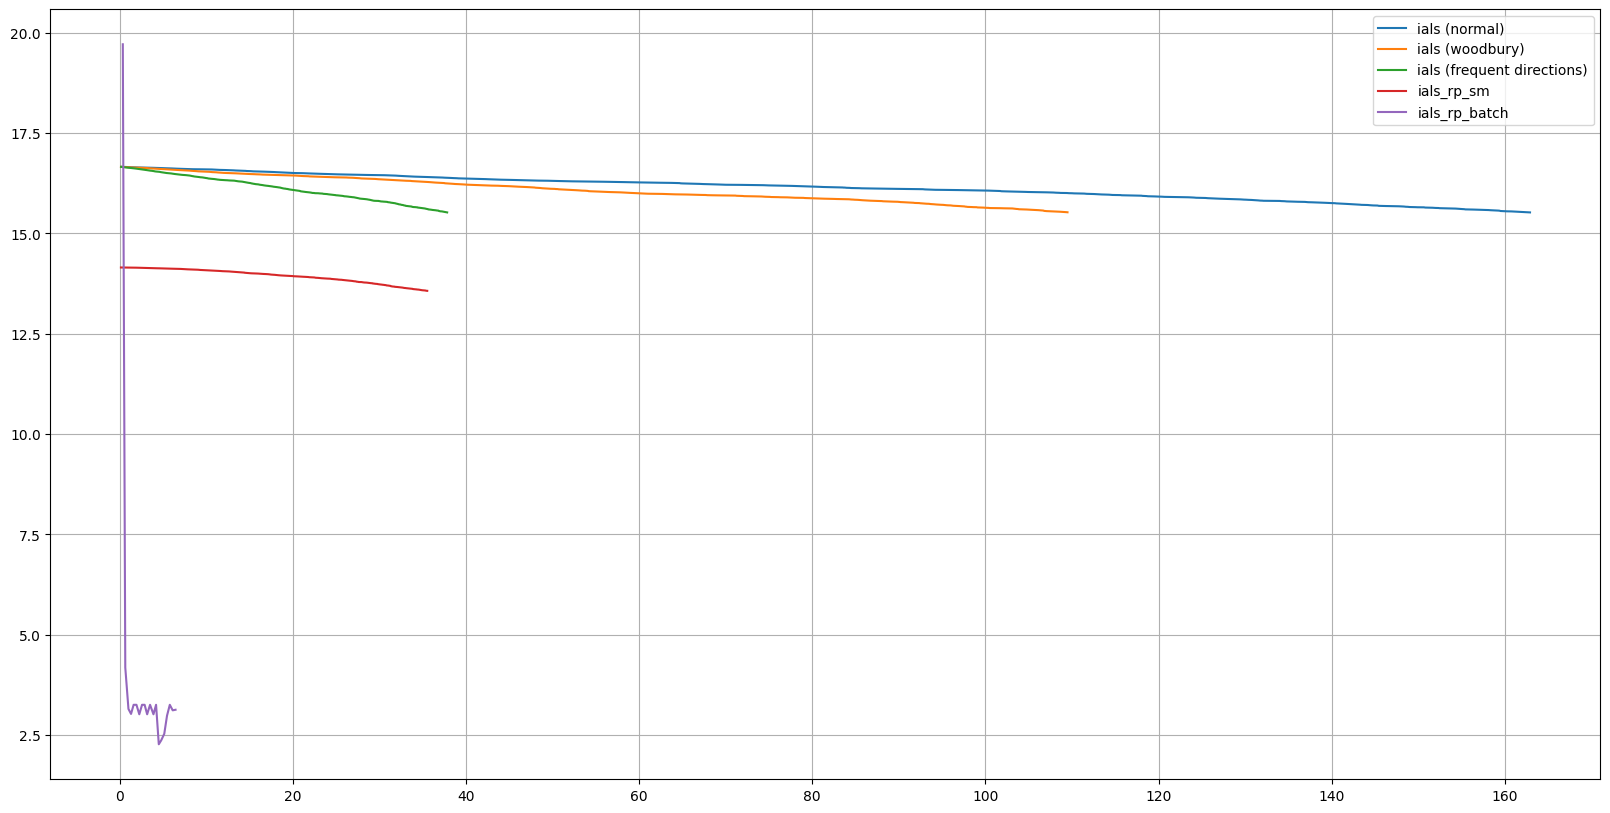

In [46]:
plt.figure(figsize = (20, 10))
plt.grid()
plt.plot(times_ials, losses_ials, label = "ials (normal)")
plt.plot(times_ials_lr, losses_ials_lr, label = "ials (woodbury)")
plt.plot(times_fd, losses_fd, label = "ials (frequent directions)")
plt.plot(times_rp_sm, losses_rp_sm, label = "ials_rp_sm")
plt.plot(times_rp_batch, losses_rp_batch, label = "ials_rp_batch")
plt.legend()
plt.show()

## Подбор гиперпараметров

### iALS_pcg_fd

In [ ]:
import optuna
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from ials_mods import iALS_pcg_fd


def build_R_train_and_item2col(train: pd.DataFrame):
    train_users = train.userid.unique()
    train_items_arr = train.movieid.unique()

    user2row = {u: i for i, u in enumerate(train_users)}
    item2col = {m: j for j, m in enumerate(train_items_arr)}

    train_rows = train.userid.map(user2row).to_numpy()
    train_cols = train.movieid.map(item2col).to_numpy()
    train_vals = np.ones(len(train), dtype=np.float32)

    # разреженная матрица    
    R_train = csr_matrix(
        (train_vals, (train_rows, train_cols)),
        shape=(len(train_users), len(train_items_arr)),
        dtype=np.float32
    )
    return R_train, item2col



def make_objective(
    train: pd.DataFrame,
    test: pd.DataFrame,
    holdout: pd.DataFrame,
    R_train: csr_matrix,
    item2col: dict,
    k_eval: int = 10,
    seed: int = 42,
):

    def objective(trial: optuna.Trial) -> float:

        # потенциальные гиперпараметры
        rank = trial.suggest_int("rank", 8, 128, log=True)
        iters = trial.suggest_int("iters", 200, 3000, log=True)
        l2 = trial.suggest_float("l2", 1e-2, 1e2, log=True)
        ell_mult = trial.suggest_int("ell_mult", 1, 8)
        precond_refresh = trial.suggest_int("precond_refresh", 5, 100, log=True)
        tol = trial.suggest_float("tol", 1e-6, 1e-3, log=True)
        cg_maxiter = trial.suggest_int("cg_maxiter", 10, 200, log=True)
        weight_kind = trial.suggest_categorical("weight_kind", ["log1p", "linear_alpha"])
        if weight_kind == "log1p":
            weight_f = np.log1p
        else:
            alpha = trial.suggest_float("alpha", 1.0, 200.0, log=True)
            weight_f = lambda x, a=alpha: a * x

        # обучение
        np.random.seed(seed)
        t0 = time.time()
        P, Q, losses, times_ = iALS_pcg_fd(
            R_train,
            rank=rank,
            weight_f=weight_f,
            iters=iters,
            l2=l2,
            ell_mult=ell_mult,
            precond_refresh=precond_refresh,
            tol=tol,
            cg_maxiter=cg_maxiter
        )
        train_time = time.time() - t0

        metrics, _, _ = run_eval_timepoint_warmstart(
            train=train,
            test=test,
            holdout=holdout,
            Q=Q,
            item2col=item2col,
            l2=l2,          
            weight_f=weight_f,
            k=k_eval,
        )

        trial.set_user_attr("train_time_sec", float(train_time))
        if losses is not None and len(losses) > 0:
            trial.set_user_attr("last_loss", float(losses[-1]))

        # метрика
        return float(metrics[f"HR@{k_eval}"])

    return objective


def tune_ials_with_optuna(
    ratings: pd.DataFrame,
    time_split_q: float = 0.95,
    k_eval: int = 10,
    n_trials: int = 10,
    seed: int = 42,
    sampler_seed: int = 123,
):
    train, test, holdout = timepoint_split(ratings, time_split_q=time_split_q)
    R_train, item2col = build_R_train_and_item2col(train)

    sampler = optuna.samplers.TPESampler(seed=sampler_seed)
    study = optuna.create_study(direction="maximize", sampler=sampler)

    objective = make_objective(train, test, holdout, R_train, item2col, k_eval=k_eval, seed=seed)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    # закинем результаты в df
    rows = []
    for t in study.trials:
        if t.value is None:
            continue
        row = dict(t.params)
        row["HR@k"] = t.value
        row["k"] = k_eval
        row["state"] = str(t.state)
        row["train_time_sec"] = t.user_attrs.get("train_time_sec", np.nan)
        row["last_loss"] = t.user_attrs.get("last_loss", np.nan)
        rows.append(row)
    df = pd.DataFrame(rows).sort_values("HR@k", ascending=False).reset_index(drop=True)

    return study, df, (train, test, holdout), (R_train, item2col)

study, df_results, splits, artifacts = tune_ials_with_optuna(
    ratings=ratings,
    time_split_q=0.95,
    k_eval=10,
    n_trials=50,
    seed=42,
    sampler_seed=123,
)
print("Best HR@10:", study.best_value)
print("Best params:", study.best_params)
display(df_results.head(10))


/Users/mariaselifanova/Desktop/проверка_дз/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-12-24 17:00:03,596] A new study created in memory with name: no-name-e86d935f-e756-4126-a105-c5c8362737ae
Best trial: 0. Best value: 0.0112219:   2%|▏         | 1/50 [00:25<20:35, 25.22s/it]

[I 2025-12-24 17:00:28,815] Trial 0 finished with value: 0.011221945137157107 and parameters: {'rank': 54, 'iters': 433, 'l2': 0.08079896808319473, 'ell_mult': 5, 'precond_refresh': 42, 'tol': 1.8591711878786356e-05, 'cg_maxiter': 189, 'weight_kind': 'log1p'}. Best is trial 0 with value: 0.011221945137157107.


Best trial: 0. Best value: 0.0112219:   4%|▍         | 2/50 [00:51<20:51, 26.07s/it]

[I 2025-12-24 17:00:55,476] Trial 1 finished with value: 0.004987531172069825 and parameters: {'rank': 23, 'iters': 506, 'l2': 8.24515509895362, 'ell_mult': 4, 'precond_refresh': 5, 'tol': 1.563625577729034e-05, 'cg_maxiter': 90, 'weight_kind': 'log1p'}. Best is trial 0 with value: 0.011221945137157107.


Best trial: 2. Best value: 0.0137157:   6%|▌         | 3/50 [01:27<23:57, 30.59s/it]

[I 2025-12-24 17:01:31,448] Trial 2 finished with value: 0.01371571072319202 and parameters: {'rank': 34, 'iters': 843, 'l2': 3.448290408913144, 'ell_mult': 7, 'precond_refresh': 43, 'tol': 6.808799287054754e-05, 'cg_maxiter': 86, 'weight_kind': 'linear_alpha', 'alpha': 3.3515101667721}. Best is trial 2 with value: 0.01371571072319202.


Best trial: 2. Best value: 0.0137157:   8%|▊         | 4/50 [02:12<27:38, 36.05s/it]

[I 2025-12-24 17:02:15,873] Trial 3 finished with value: 0.008728179551122194 and parameters: {'rank': 17, 'iters': 1103, 'l2': 0.023357145158910436, 'ell_mult': 4, 'precond_refresh': 17, 'tol': 3.0272988293379077e-05, 'cg_maxiter': 35, 'weight_kind': 'linear_alpha', 'alpha': 113.68816640976891}. Best is trial 2 with value: 0.01371571072319202.


Best trial: 2. Best value: 0.0137157:  10%|█         | 5/50 [04:01<46:53, 62.52s/it]

[I 2025-12-24 17:04:05,303] Trial 4 finished with value: 0.006234413965087282 and parameters: {'rank': 110, 'iters': 778, 'l2': 3.1319282717196035, 'ell_mult': 1, 'precond_refresh': 12, 'tol': 1.7558145187330864e-05, 'cg_maxiter': 133, 'weight_kind': 'linear_alpha', 'alpha': 185.26894531844354}. Best is trial 2 with value: 0.01371571072319202.


Best trial: 2. Best value: 0.0137157:  12%|█▏        | 6/50 [04:50<42:26, 57.88s/it]

[I 2025-12-24 17:04:54,168] Trial 5 finished with value: 0.006234413965087282 and parameters: {'rank': 33, 'iters': 1051, 'l2': 0.030374886510756916, 'ell_mult': 7, 'precond_refresh': 29, 'tol': 4.3172184004200446e-05, 'cg_maxiter': 27, 'weight_kind': 'linear_alpha', 'alpha': 36.95672668900971}. Best is trial 2 with value: 0.01371571072319202.


Best trial: 6. Best value: 0.0187032:  14%|█▍        | 7/50 [05:56<43:15, 60.35s/it]

[I 2025-12-24 17:05:59,618] Trial 6 finished with value: 0.018703241895261846 and parameters: {'rank': 90, 'iters': 796, 'l2': 4.756145497401288, 'ell_mult': 5, 'precond_refresh': 31, 'tol': 0.00010569809326914983, 'cg_maxiter': 124, 'weight_kind': 'linear_alpha', 'alpha': 3.6365003754324956}. Best is trial 6 with value: 0.018703241895261846.


Best trial: 6. Best value: 0.0187032:  16%|█▌        | 8/50 [06:29<36:20, 51.92s/it]

[I 2025-12-24 17:06:33,495] Trial 7 finished with value: 0.008728179551122194 and parameters: {'rank': 13, 'iters': 942, 'l2': 0.024146270773370455, 'ell_mult': 8, 'precond_refresh': 32, 'tol': 0.00014799569228952922, 'cg_maxiter': 10, 'weight_kind': 'log1p'}. Best is trial 6 with value: 0.018703241895261846.


Best trial: 6. Best value: 0.0187032:  18%|█▊        | 9/50 [06:40<26:41, 39.05s/it]

[I 2025-12-24 17:06:44,248] Trial 8 finished with value: 0.003740648379052369 and parameters: {'rank': 12, 'iters': 302, 'l2': 6.055055317201643, 'ell_mult': 3, 'precond_refresh': 39, 'tol': 4.6041530209189814e-05, 'cg_maxiter': 31, 'weight_kind': 'log1p'}. Best is trial 6 with value: 0.018703241895261846.


Best trial: 6. Best value: 0.0187032:  20%|██        | 10/50 [06:49<19:43, 29.59s/it]

[I 2025-12-24 17:06:52,649] Trial 9 finished with value: 0.006234413965087282 and parameters: {'rank': 21, 'iters': 225, 'l2': 0.16560456096344595, 'ell_mult': 4, 'precond_refresh': 40, 'tol': 0.0009684460811380895, 'cg_maxiter': 28, 'weight_kind': 'log1p'}. Best is trial 6 with value: 0.018703241895261846.


Best trial: 10. Best value: 0.0386534:  22%|██▏       | 11/50 [10:15<54:28, 83.82s/it]

[I 2025-12-24 17:10:19,426] Trial 10 finished with value: 0.03865336658354115 and parameters: {'rank': 123, 'iters': 2416, 'l2': 84.93676871612902, 'ell_mult': 1, 'precond_refresh': 97, 'tol': 1.4059683501670634e-06, 'cg_maxiter': 63, 'weight_kind': 'linear_alpha', 'alpha': 1.1664742590050132}. Best is trial 10 with value: 0.03865336658354115.


Best trial: 10. Best value: 0.0386534:  24%|██▍       | 12/50 [14:39<1:27:46, 138.60s/it]

[I 2025-12-24 17:14:43,319] Trial 11 finished with value: 0.02743142144638404 and parameters: {'rank': 128, 'iters': 2965, 'l2': 71.27077624882915, 'ell_mult': 1, 'precond_refresh': 95, 'tol': 1.0639169804273708e-06, 'cg_maxiter': 65, 'weight_kind': 'linear_alpha', 'alpha': 1.0911410845455616}. Best is trial 10 with value: 0.03865336658354115.


Best trial: 10. Best value: 0.0386534:  26%|██▌       | 13/50 [17:49<1:35:06, 154.22s/it]

[I 2025-12-24 17:17:53,489] Trial 12 finished with value: 0.03865336658354115 and parameters: {'rank': 59, 'iters': 2985, 'l2': 77.83597057892325, 'ell_mult': 1, 'precond_refresh': 85, 'tol': 1.0744223085951263e-06, 'cg_maxiter': 87, 'weight_kind': 'linear_alpha', 'alpha': 1.0178083342302968}. Best is trial 10 with value: 0.03865336658354115.


Best trial: 10. Best value: 0.0386534:  28%|██▊       | 14/50 [20:56<1:38:26, 164.08s/it]

[I 2025-12-24 17:21:00,355] Trial 13 finished with value: 0.02743142144638404 and parameters: {'rank': 65, 'iters': 2895, 'l2': 76.45827472607432, 'ell_mult': 2, 'precond_refresh': 94, 'tol': 1.7082650553105943e-06, 'cg_maxiter': 50, 'weight_kind': 'linear_alpha', 'alpha': 1.0385520014493836}. Best is trial 10 with value: 0.03865336658354115.


Best trial: 10. Best value: 0.0386534:  30%|███       | 15/50 [22:44<1:25:48, 147.11s/it]

[I 2025-12-24 17:22:48,127] Trial 14 finished with value: 0.02743142144638404 and parameters: {'rank': 61, 'iters': 1981, 'l2': 28.02576105983749, 'ell_mult': 2, 'precond_refresh': 71, 'tol': 4.181931451723272e-06, 'cg_maxiter': 14, 'weight_kind': 'linear_alpha', 'alpha': 4.427611477847108}. Best is trial 10 with value: 0.03865336658354115.


Best trial: 10. Best value: 0.0386534:  32%|███▏      | 16/50 [23:41<1:07:59, 119.98s/it]

[I 2025-12-24 17:23:45,102] Trial 15 finished with value: 0.0024937655860349127 and parameters: {'rank': 8, 'iters': 1615, 'l2': 21.51107249880903, 'ell_mult': 2, 'precond_refresh': 67, 'tol': 3.301379899284188e-06, 'cg_maxiter': 55, 'weight_kind': 'linear_alpha', 'alpha': 8.385286431369563}. Best is trial 10 with value: 0.03865336658354115.


Best trial: 10. Best value: 0.0386534:  34%|███▍      | 17/50 [26:06<1:10:09, 127.55s/it]

[I 2025-12-24 17:26:10,253] Trial 16 finished with value: 0.02119700748129676 and parameters: {'rank': 85, 'iters': 1882, 'l2': 0.8324156925436732, 'ell_mult': 1, 'precond_refresh': 58, 'tol': 5.175391229800266e-06, 'cg_maxiter': 79, 'weight_kind': 'linear_alpha', 'alpha': 1.7799781124345162}. Best is trial 10 with value: 0.03865336658354115.


Best trial: 10. Best value: 0.0386534:  36%|███▌      | 18/50 [27:54<1:04:50, 121.59s/it]

[I 2025-12-24 17:27:57,985] Trial 17 finished with value: 0.008728179551122194 and parameters: {'rank': 46, 'iters': 1533, 'l2': 25.105108528144946, 'ell_mult': 3, 'precond_refresh': 8, 'tol': 1.0012471119215671e-06, 'cg_maxiter': 19, 'weight_kind': 'linear_alpha', 'alpha': 19.026310149827875}. Best is trial 10 with value: 0.03865336658354115.


Best trial: 10. Best value: 0.0386534:  38%|███▊      | 19/50 [29:56<1:02:51, 121.66s/it]

[I 2025-12-24 17:29:59,798] Trial 18 finished with value: 0.03117206982543641 and parameters: {'rank': 41, 'iters': 2293, 'l2': 0.8300006939755089, 'ell_mult': 3, 'precond_refresh': 20, 'tol': 8.078956212554285e-06, 'cg_maxiter': 131, 'weight_kind': 'linear_alpha', 'alpha': 2.320741906373488}. Best is trial 10 with value: 0.03865336658354115.


Best trial: 10. Best value: 0.0386534:  40%|████      | 20/50 [31:25<55:56, 111.89s/it]  

[I 2025-12-24 17:31:28,907] Trial 19 finished with value: 0.012468827930174564 and parameters: {'rank': 81, 'iters': 1383, 'l2': 74.72476238971551, 'ell_mult': 1, 'precond_refresh': 100, 'tol': 2.273880621205179e-06, 'cg_maxiter': 41, 'weight_kind': 'linear_alpha', 'alpha': 5.709682657317752}. Best is trial 10 with value: 0.03865336658354115.


Best trial: 10. Best value: 0.0386534:  42%|████▏     | 21/50 [35:14<1:11:06, 147.12s/it]

[I 2025-12-24 17:35:18,187] Trial 20 finished with value: 0.018703241895261846 and parameters: {'rank': 102, 'iters': 2395, 'l2': 13.596723619766882, 'ell_mult': 2, 'precond_refresh': 61, 'tol': 0.0003157216275266575, 'cg_maxiter': 190, 'weight_kind': 'linear_alpha', 'alpha': 13.420471456782131}. Best is trial 10 with value: 0.03865336658354115.


Best trial: 10. Best value: 0.0386534:  44%|████▍     | 22/50 [37:20<1:05:43, 140.85s/it]

[I 2025-12-24 17:37:24,412] Trial 21 finished with value: 0.0199501246882793 and parameters: {'rank': 42, 'iters': 2193, 'l2': 0.8431576998506437, 'ell_mult': 3, 'precond_refresh': 20, 'tol': 7.711620812068961e-06, 'cg_maxiter': 120, 'weight_kind': 'linear_alpha', 'alpha': 2.025486143889692}. Best is trial 10 with value: 0.03865336658354115.


Best trial: 10. Best value: 0.0386534:  44%|████▍     | 22/50 [41:06<52:18, 112.10s/it]  


[W 2025-12-24 17:41:09,668] Trial 22 failed with parameters: {'rank': 72, 'iters': 2619, 'l2': 0.24499048265783757, 'ell_mult': 2, 'precond_refresh': 15, 'tol': 8.337956547272651e-06, 'cg_maxiter': 102, 'weight_kind': 'linear_alpha', 'alpha': 1.9461018708102833} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/mariaselifanova/Desktop/проверка_дз/.venv/lib/python3.13/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/vv/10r9kg5s3vg5wb6hts5tbgfm0000gn/T/ipykernel_17223/2571394725.py", line 82, in objective
    P, Q, losses, times_ = iALS_pcg_fd(
                           ~~~~~~~~~~~^
        R_train,
        ^^^^^^^^
    ...<7 lines>...
        cg_maxiter=cg_maxiter
        ^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/Users/mariaselifanova/Desktop/проверка_дз/ials_mods.py", line 249, in iALS_pcg_fd
    qj, it_i = pcg(A_item_mv, b, Mp_solve, tol=tol, maxiter=cg_maxite

KeyboardInterrupt: 

### ials

In [56]:
def make_objective_ials(
    train: pd.DataFrame,
    test: pd.DataFrame,
    holdout: pd.DataFrame,
    R_train: csr_matrix,
    item2col: dict,
    k_eval: int = 10,
    seed: int = 42,
):
    def objective(trial: optuna.Trial) -> float:
        rank = trial.suggest_int("rank", 8, 128, log=True)
        iters = trial.suggest_int("iters", 200, 5000, log=True)
        l2 = trial.suggest_float("l2", 1e-3, 1e2, log=True)

        weight_kind = trial.suggest_categorical("weight_kind", ["log1p", "linear_alpha"])
        if weight_kind == "log1p":
            weight_f = np.log1p
        else:
            alpha = trial.suggest_float("alpha", 1.0, 200.0, log=True)
            weight_f = lambda x, a=alpha: a * x


        np.random.seed(seed)
        t0 = time.time()
        P, Q, losses, times_ = iALS(
            R_train,
            rank=rank,
            weight_f=weight_f,
            iters=iters,
            l2=l2
        )
        train_time = time.time() - t0

        metrics, _, _ = run_eval_timepoint_warmstart(
            train=train,
            test=test,
            holdout=holdout,
            Q=Q,
            item2col=item2col,
            l2=l2,
            weight_f=weight_f,
            k=k_eval,
        )

        trial.set_user_attr("train_time_sec", float(train_time))
        if losses is not None and len(losses) > 0:
            trial.set_user_attr("last_loss", float(losses[-1]))

        return float(metrics[f"HR@{k_eval}"])
    return objective

def tune_ials_with_optuna(
    ratings: pd.DataFrame,
    time_split_q: float = 0.95,
    k_eval: int = 10,
    n_trials: int = 10,
    seed: int = 42,
    sampler_seed: int = 123,
):
    train, test, holdout = timepoint_split(ratings, time_split_q=time_split_q)
    R_train, item2col = build_R_train_and_item2col(train)
    sampler = optuna.samplers.TPESampler(seed=sampler_seed)
    study = optuna.create_study(direction="maximize", sampler=sampler)

    objective = make_objective_ials(train, test, holdout, R_train, item2col, k_eval=k_eval, seed=seed)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    rows = []
    for t in study.trials:
        if t.value is None:
            continue
        row = dict(t.params)
        row["HR@k"] = t.value
        row["k"] = k_eval
        row["state"] = str(t.state)
        row["train_time_sec"] = t.user_attrs.get("train_time_sec", np.nan)
        row["last_loss"] = t.user_attrs.get("last_loss", np.nan)
        rows.append(row)
    df = pd.DataFrame(rows).sort_values("HR@k", ascending=False).reset_index(drop=True)

    return study, df, (train, test, holdout), (R_train, item2col)

study_ials, df_ials, splits, artifacts = tune_ials_with_optuna(
    ratings=ratings,
    time_split_q=0.95,
    k_eval=10,
    n_trials=15,
    seed=42,
    sampler_seed=123)
print("Best HR@10:", study_ials.best_value)
print("Best params:", study_ials.best_params)
display(df_ials.head(10))


[I 2025-12-24 20:31:58,795] A new study created in memory with name: no-name-f22ee939-1536-4db9-92c0-8b58818ee245
Best trial: 0. Best value: 0.0112219:   7%|▋         | 1/15 [02:13<31:04, 133.19s/it]

[I 2025-12-24 20:34:11,984] Trial 0 finished with value: 0.011221945137157107 and parameters: {'rank': 54, 'iters': 502, 'l2': 0.013622514154189571, 'weight_kind': 'linear_alpha', 'alpha': 9.409805704126496}. Best is trial 0 with value: 0.011221945137157107.


Best trial: 1. Best value: 0.042394:  13%|█▎        | 2/15 [15:36<1:54:13, 527.19s/it]

[I 2025-12-24 20:47:34,970] Trial 1 finished with value: 0.04239401496259352 and parameters: {'rank': 122, 'iters': 1812, 'l2': 0.2538981330307094, 'weight_kind': 'log1p'}. Best is trial 1 with value: 0.04239401496259352.


Best trial: 1. Best value: 0.042394:  20%|██        | 3/15 [19:39<1:19:32, 397.69s/it]

[I 2025-12-24 20:51:38,555] Trial 2 finished with value: 0.014962593516209476 and parameters: {'rank': 60, 'iters': 819, 'l2': 0.001987876881680065, 'weight_kind': 'linear_alpha', 'alpha': 2.6297771393597316}. Best is trial 1 with value: 0.04239401496259352.


Best trial: 1. Best value: 0.042394:  27%|██▋       | 4/15 [22:42<57:20, 312.80s/it]  

[I 2025-12-24 20:54:41,230] Trial 3 finished with value: 0.004987531172069825 and parameters: {'rank': 12, 'iters': 1106, 'l2': 0.45618178001453985, 'weight_kind': 'linear_alpha', 'alpha': 46.45082513293351}. Best is trial 1 with value: 0.04239401496259352.


Best trial: 1. Best value: 0.042394:  33%|███▎      | 5/15 [31:48<1:06:10, 397.08s/it]

[I 2025-12-24 21:03:47,752] Trial 4 finished with value: 0.029925187032418952 and parameters: {'rank': 43, 'iters': 2045, 'l2': 0.04119026341053771, 'weight_kind': 'log1p'}. Best is trial 1 with value: 0.04239401496259352.


Best trial: 1. Best value: 0.042394:  40%|████      | 6/15 [36:38<54:04, 360.51s/it]  

[I 2025-12-24 21:08:37,261] Trial 5 finished with value: 0.016209476309226933 and parameters: {'rank': 17, 'iters': 1523, 'l2': 0.0028875179969637577, 'weight_kind': 'log1p'}. Best is trial 1 with value: 0.04239401496259352.


Best trial: 1. Best value: 0.042394:  47%|████▋     | 7/15 [39:32<39:56, 299.56s/it]

[I 2025-12-24 21:11:31,337] Trial 6 finished with value: 0.003740648379052369 and parameters: {'rank': 30, 'iters': 787, 'l2': 0.036417163407038725, 'weight_kind': 'linear_alpha', 'alpha': 148.7786188053069}. Best is trial 1 with value: 0.04239401496259352.


Best trial: 1. Best value: 0.042394:  53%|█████▎    | 8/15 [45:49<37:49, 324.21s/it]

[I 2025-12-24 21:17:48,338] Trial 7 finished with value: 0.007481296758104738 and parameters: {'rank': 31, 'iters': 1489, 'l2': 0.0037852274022047035, 'weight_kind': 'linear_alpha', 'alpha': 98.49254460390851}. Best is trial 1 with value: 0.04239401496259352.


Best trial: 1. Best value: 0.042394:  60%|██████    | 9/15 [48:25<27:09, 271.53s/it]

[I 2025-12-24 21:20:24,031] Trial 8 finished with value: 0.014962593516209476 and parameters: {'rank': 15, 'iters': 946, 'l2': 84.68352511202686, 'weight_kind': 'linear_alpha', 'alpha': 1.8948296801003488}. Best is trial 1 with value: 0.04239401496259352.


Best trial: 1. Best value: 0.042394:  67%|██████▋   | 10/15 [57:51<30:13, 362.65s/it]

[I 2025-12-24 21:29:50,706] Trial 9 finished with value: 0.02743142144638404 and parameters: {'rank': 78, 'iters': 1392, 'l2': 0.5313002647635514, 'weight_kind': 'log1p'}. Best is trial 1 with value: 0.04239401496259352.


Best trial: 1. Best value: 0.042394:  67%|██████▋   | 10/15 [1:40:28<50:14, 602.81s/it]


[W 2025-12-24 22:12:26,842] Trial 10 failed with parameters: {'rank': 123, 'iters': 4923, 'l2': 9.055094147080283, 'weight_kind': 'log1p'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/mariaselifanova/Desktop/проверка_дз/.venv/lib/python3.13/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/vv/10r9kg5s3vg5wb6hts5tbgfm0000gn/T/ipykernel_17223/1096756885.py", line 25, in objective
    P, Q, losses, times_ = iALS(
                           ~~~~^
        R_train,
        ^^^^^^^^
    ...<3 lines>...
        l2=l2
        ^^^^^
    )
    ^
  File "/var/folders/vv/10r9kg5s3vg5wb6hts5tbgfm0000gn/T/ipykernel_17223/3236811485.py", line 24, in iALS
    Q[j] = (np.linalg.inv(P.T @ P + P.T @ weights_j @ P + l2 * np.eye(rank)) @ (P.T + P.T @ weights_j) @ ratings[:, j]).T
                                                                                                      

KeyboardInterrupt: 

### ials_LR

In [71]:
def make_objective_ials_lr(
    train: pd.DataFrame,
    test: pd.DataFrame,
    holdout: pd.DataFrame,
    R_train,
    item2col: dict,
    k_eval: int = 10,
    seed: int = 42,
):
    def objective(trial: optuna.Trial) -> float:
        rank = trial.suggest_categorical("rank", [8, 16, 32, 64])
        iters = trial.suggest_int("iters", 200, 1500, log=True)
        l2 = trial.suggest_categorical("l2", [0.1, 1.0, 10.0])
        weight_kind = trial.suggest_categorical("weight_kind", ["log1p", "alpha"])
        if weight_kind == "log1p":
            weight_f = np.log1p
        else:
            alpha = trial.suggest_float("alpha", 5.0, 200.0, log=True)
            weight_f = lambda x, a=alpha: a * x

        np.random.seed(seed)
        t0 = time.time()
        P, Q, losses, times_ = iALS_LR(
            R_train,
            rank=rank,
            weight_f=weight_f,
            iters=iters,
            l2=l2
        )
        train_time = time.time() - t0

        metrics, _, _ = run_eval_timepoint_warmstart(
            train=train,
            test=test,
            holdout=holdout,
            Q=Q,
            item2col=item2col,
            l2=l2,
            weight_f=weight_f,
            k=k_eval,
        )

        trial.set_user_attr("train_time_sec", float(train_time))
        if losses is not None and len(losses) > 0:
            trial.set_user_attr("last_loss", float(losses[-1]))

        return float(metrics[f"HR@{k_eval}"])

    return objective


def tune_ials_lr_with_optuna(
    train: pd.DataFrame,
    test: pd.DataFrame,
    holdout: pd.DataFrame,
    R_train,
    item2col: dict,
    k_eval: int = 10,
    n_trials: int = 50,
    seed: int = 42,
    sampler_seed: int = 123,
):
    sampler = optuna.samplers.TPESampler(seed=sampler_seed)
    study = optuna.create_study(direction="maximize", sampler=sampler)

    objective = make_objective_ials_lr(
        train=train, test=test, holdout=holdout,
        R_train=R_train, item2col=item2col,
        k_eval=k_eval, seed=seed
    )

    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    rows = []
    for t in study.trials:
        if t.value is None:
            continue
        row = dict(t.params)
        row[f"HR@{k_eval}"] = float(t.value)
        row["state"] = str(t.state)
        row["train_time_sec"] = t.user_attrs.get("train_time_sec", np.nan)
        row["last_loss"] = t.user_attrs.get("last_loss", np.nan)
        rows.append(row)

    df = pd.DataFrame(rows).sort_values(f"HR@{k_eval}", ascending=False).reset_index(drop=True)
    return study, df

study_lr, df_lr = tune_ials_lr_with_optuna(
    train=train,
    test=test,
    holdout=holdout,
    R_train=R_train,
    item2col=item2col,
    k_eval=10,
    n_trials=20,
    seed=42,
    sampler_seed=123,
)
print("Best:", study_lr.best_value, study_lr.best_params)
display(df_lr.head(10))


[I 2025-12-24 23:11:57,215] A new study created in memory with name: no-name-0c39335b-0e4b-4a44-91a6-113f803e8f5e
Best trial: 0. Best value: 0.00997506:   5%|▌         | 1/20 [00:35<11:10, 35.31s/it]

[I 2025-12-24 23:12:32,523] Trial 0 finished with value: 0.00997506234413965 and parameters: {'rank': 8, 'iters': 852, 'l2': 1.0, 'weight_kind': 'log1p'}. Best is trial 0 with value: 0.00997506234413965.


Best trial: 0. Best value: 0.00997506:  10%|█         | 2/20 [00:56<08:02, 26.80s/it]

[I 2025-12-24 23:12:53,368] Trial 1 finished with value: 0.0012468827930174563 and parameters: {'rank': 16, 'iters': 445, 'l2': 0.1, 'weight_kind': 'alpha', 'alpha': 51.918053125203656}. Best is trial 0 with value: 0.00997506234413965.


Best trial: 0. Best value: 0.00997506:  15%|█▌        | 3/20 [01:12<06:17, 22.19s/it]

[I 2025-12-24 23:13:10,069] Trial 2 finished with value: 0.003740648379052369 and parameters: {'rank': 8, 'iters': 383, 'l2': 0.1, 'weight_kind': 'log1p'}. Best is trial 0 with value: 0.00997506234413965.


Best trial: 0. Best value: 0.00997506:  20%|██        | 4/20 [01:29<05:17, 19.86s/it]

[I 2025-12-24 23:13:26,348] Trial 3 finished with value: 0.003740648379052369 and parameters: {'rank': 32, 'iters': 375, 'l2': 10.0, 'weight_kind': 'alpha', 'alpha': 7.659450420899638}. Best is trial 0 with value: 0.00997506234413965.


Best trial: 0. Best value: 0.00997506:  25%|██▌       | 5/20 [01:56<05:36, 22.41s/it]

[I 2025-12-24 23:13:53,279] Trial 4 finished with value: 0.006234413965087282 and parameters: {'rank': 32, 'iters': 529, 'l2': 0.1, 'weight_kind': 'alpha', 'alpha': 46.24965616795778}. Best is trial 0 with value: 0.00997506234413965.


Best trial: 0. Best value: 0.00997506:  30%|███       | 6/20 [02:29<06:05, 26.11s/it]

[I 2025-12-24 23:14:26,573] Trial 5 finished with value: 0.007481296758104738 and parameters: {'rank': 8, 'iters': 789, 'l2': 0.1, 'weight_kind': 'alpha', 'alpha': 60.23686200225051}. Best is trial 0 with value: 0.00997506234413965.


Best trial: 0. Best value: 0.00997506:  35%|███▌      | 7/20 [02:41<04:41, 21.66s/it]

[I 2025-12-24 23:14:39,068] Trial 6 finished with value: 0.0024937655860349127 and parameters: {'rank': 8, 'iters': 295, 'l2': 10.0, 'weight_kind': 'alpha', 'alpha': 5.306521902107971}. Best is trial 0 with value: 0.00997506234413965.


Best trial: 0. Best value: 0.00997506:  40%|████      | 8/20 [03:15<05:05, 25.43s/it]

[I 2025-12-24 23:15:12,566] Trial 7 finished with value: 0.007481296758104738 and parameters: {'rank': 8, 'iters': 812, 'l2': 1.0, 'weight_kind': 'alpha', 'alpha': 111.52592456562499}. Best is trial 0 with value: 0.00997506234413965.


Best trial: 8. Best value: 0.0112219:  45%|████▌     | 9/20 [03:58<05:40, 30.92s/it] 

[I 2025-12-24 23:15:55,527] Trial 8 finished with value: 0.011221945137157107 and parameters: {'rank': 64, 'iters': 827, 'l2': 0.1, 'weight_kind': 'alpha', 'alpha': 8.731427441150146}. Best is trial 8 with value: 0.011221945137157107.


Best trial: 8. Best value: 0.0112219:  50%|█████     | 10/20 [04:41<05:47, 34.78s/it]

[I 2025-12-24 23:16:38,989] Trial 9 finished with value: 0.004987531172069825 and parameters: {'rank': 64, 'iters': 766, 'l2': 10.0, 'weight_kind': 'alpha', 'alpha': 38.48765592248105}. Best is trial 8 with value: 0.011221945137157107.


Best trial: 10. Best value: 0.0261845:  55%|█████▌    | 11/20 [06:06<07:30, 50.09s/it]

[I 2025-12-24 23:18:03,787] Trial 10 finished with value: 0.026184538653366583 and parameters: {'rank': 64, 'iters': 1487, 'l2': 0.1, 'weight_kind': 'log1p'}. Best is trial 10 with value: 0.026184538653366583.


Best trial: 10. Best value: 0.0261845:  60%|██████    | 12/20 [08:03<09:23, 70.44s/it]

[I 2025-12-24 23:20:00,779] Trial 11 finished with value: 0.02493765586034913 and parameters: {'rank': 64, 'iters': 1409, 'l2': 0.1, 'weight_kind': 'log1p'}. Best is trial 10 with value: 0.026184538653366583.


Best trial: 10. Best value: 0.0261845:  65%|██████▌   | 13/20 [09:26<08:39, 74.20s/it]

[I 2025-12-24 23:21:23,614] Trial 12 finished with value: 0.026184538653366583 and parameters: {'rank': 64, 'iters': 1499, 'l2': 0.1, 'weight_kind': 'log1p'}. Best is trial 10 with value: 0.026184538653366583.


Best trial: 10. Best value: 0.0261845:  70%|███████   | 14/20 [10:46<07:35, 75.86s/it]

[I 2025-12-24 23:22:43,331] Trial 13 finished with value: 0.02493765586034913 and parameters: {'rank': 64, 'iters': 1449, 'l2': 0.1, 'weight_kind': 'log1p'}. Best is trial 10 with value: 0.026184538653366583.


Best trial: 10. Best value: 0.0261845:  75%|███████▌  | 15/20 [11:52<06:04, 72.97s/it]

[I 2025-12-24 23:23:49,579] Trial 14 finished with value: 0.022443890274314215 and parameters: {'rank': 64, 'iters': 1138, 'l2': 0.1, 'weight_kind': 'log1p'}. Best is trial 10 with value: 0.026184538653366583.


Best trial: 10. Best value: 0.0261845:  80%|████████  | 16/20 [12:02<03:36, 54.13s/it]

[I 2025-12-24 23:23:59,966] Trial 15 finished with value: 0.0 and parameters: {'rank': 16, 'iters': 200, 'l2': 1.0, 'weight_kind': 'log1p'}. Best is trial 10 with value: 0.026184538653366583.


Best trial: 10. Best value: 0.0261845:  85%|████████▌ | 17/20 [13:26<03:09, 63.15s/it]

[I 2025-12-24 23:25:24,088] Trial 16 finished with value: 0.022443890274314215 and parameters: {'rank': 64, 'iters': 1105, 'l2': 0.1, 'weight_kind': 'log1p'}. Best is trial 10 with value: 0.026184538653366583.


Best trial: 10. Best value: 0.0261845:  90%|█████████ | 18/20 [15:13<02:32, 76.30s/it]

[I 2025-12-24 23:27:10,986] Trial 17 finished with value: 0.022443890274314215 and parameters: {'rank': 64, 'iters': 1127, 'l2': 0.1, 'weight_kind': 'log1p'}. Best is trial 10 with value: 0.026184538653366583.


Best trial: 10. Best value: 0.0261845:  95%|█████████▌| 19/20 [16:11<01:10, 70.85s/it]

[I 2025-12-24 23:28:09,151] Trial 18 finished with value: 0.01371571072319202 and parameters: {'rank': 64, 'iters': 600, 'l2': 10.0, 'weight_kind': 'log1p'}. Best is trial 10 with value: 0.026184538653366583.


Best trial: 10. Best value: 0.0261845: 100%|██████████| 20/20 [17:31<00:00, 52.60s/it]

[I 2025-12-24 23:29:29,137] Trial 19 finished with value: 0.017456359102244388 and parameters: {'rank': 16, 'iters': 1492, 'l2': 1.0, 'weight_kind': 'log1p'}. Best is trial 10 with value: 0.026184538653366583.
Best: 0.026184538653366583 {'rank': 64, 'iters': 1487, 'l2': 0.1, 'weight_kind': 'log1p'}


,rank,iters,l2,weight_kind,HR@10,state,train_time_sec,last_loss,alpha
0,64,1487,0.1,log1p,0.026185,TrialState.COMPLETE,84.466247,12.926540,NaN
1,64,1499,0.1,log1p,0.026185,TrialState.COMPLETE,82.470766,12.903755,NaN
2,64,1409,0.1,log1p,0.024938,TrialState.COMPLETE,116.687252,13.003444,NaN
3,64,1449,0.1,log1p,0.024938,TrialState.COMPLETE,79.370873,12.959765,NaN
4,64,1127,0.1,log1p,0.022444,TrialState.COMPLETE,106.427609,13.316941,NaN
5,64,1105,0.1,log1p,0.022444,TrialState.COMPLETE,83.649870,13.343972,NaN
6,64,1138,0.1,log1p,0.022444,TrialState.COMPLETE,65.777186,13.306143,NaN
7,16,1492,1.0,log1p,0.017456,TrialState.COMPLETE,79.678427,13.912251,NaN
8,64,600,10.0,log1p,0.013716,TrialState.COMPLETE,57.418655,13.916477,NaN
9,64,827,0.1,alpha,0.011222,TrialState.COMPLETE,42.583626,13.705144,8.731427


### iALS_RP_SM

In [52]:

def make_objective_ials_rp_sm(
    train: pd.DataFrame,
    test: pd.DataFrame,
    holdout: pd.DataFrame,
    R_train,
    item2col: dict,
    k_eval: int = 10,
    seed: int = 42,
):
    def objective(trial: optuna.Trial) -> float:

        rank = trial.suggest_categorical("rank", [16, 32, 64, 128])
        iters = trial.suggest_int("iters", 300, 3000, log=True)
        l2 = trial.suggest_categorical("l2", [0.1, 1.0, 10.0])

        proj_dim_ratio = trial.suggest_float("proj_dim_ratio", 0.1, 0.6)
        use_projection_every = trial.suggest_categorical("use_projection_every", [1, 2, 4, 8])
        weight_kind = trial.suggest_categorical("weight_kind", ["log1p", "alpha"])
        if weight_kind == "log1p":
            weight_f = np.log1p
        else:
            alpha = trial.suggest_float("alpha", 5.0, 200.0, log=True)
            weight_f = lambda x, a=alpha: a * x

        np.random.seed(seed)
        t0 = time.time()
        P, Q, losses, times_ = iALS_RP_SM(
            R_train,
            rank=rank,
            weight_f=weight_f,
            iters=iters,
            l2=l2,
            proj_dim_ratio=proj_dim_ratio,
            use_projection_every=use_projection_every,
        )
        train_time = time.time() - t0

        metrics, _, _ = run_eval_timepoint_warmstart(
            train=train,
            test=test,
            holdout=holdout,
            Q=Q,
            item2col=item2col,
            l2=l2,
            weight_f=weight_f,
            k=k_eval,
        )

        trial.set_user_attr("train_time_sec", float(train_time))
        if losses is not None and len(losses) > 0:
            trial.set_user_attr("last_loss", float(losses[-1]))

        return float(metrics[f"HR@{k_eval}"])

    return objective


def tune_ials_rp_sm_with_optuna(
    train: pd.DataFrame,
    test: pd.DataFrame,
    holdout: pd.DataFrame,
    R_train,
    item2col: dict,
    k_eval: int = 10,
    n_trials: int = 50,
    seed: int = 42,
    sampler_seed: int = 123,
):
    sampler = optuna.samplers.TPESampler(seed=sampler_seed)
    study = optuna.create_study(direction="maximize", sampler=sampler)

    objective = make_objective_ials_rp_sm(
        train=train,
        test=test,
        holdout=holdout,
        R_train=R_train,
        item2col=item2col,
        k_eval=k_eval,
        seed=seed
    )

    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    rows = []
    for t in study.trials:
        if t.value is None:
            continue
        row = dict(t.params)
        row[f"HR@{k_eval}"] = float(t.value)
        row["state"] = str(t.state)
        row["train_time_sec"] = t.user_attrs.get("train_time_sec", np.nan)
        row["last_loss"] = t.user_attrs.get("last_loss", np.nan)
        rows.append(row)

    df = pd.DataFrame(rows).sort_values(f"HR@{k_eval}", ascending=False).reset_index(drop=True)
    return study, df

study_rp, df_rp = tune_ials_rp_sm_with_optuna(
    train=train,
    test=test,
    holdout=holdout,
    R_train=R_train,
    item2col=item2col,
    k_eval=10,
    n_trials=50,
    seed=42,
    sampler_seed=123,
)
print("Best:", study_rp.best_value, study_rp.best_params)
display(df_rp.head(10))


[I 2025-12-24 18:33:05,904] A new study created in memory with name: no-name-f9db6507-c723-44cd-af4a-557709c6ad38
Best trial: 0. Best value: 0:   2%|▏         | 1/50 [00:51<42:02, 51.47s/it]

[I 2025-12-24 18:33:57,378] Trial 0 finished with value: 0.0 and parameters: {'rank': 16, 'iters': 1572, 'l2': 1.0, 'proj_dim_ratio': 0.34046595074218045, 'use_projection_every': 4, 'weight_kind': 'alpha', 'alpha': 76.08217467382906}. Best is trial 0 with value: 0.0.


Best trial: 1. Best value: 0.00498753:   4%|▍         | 2/50 [02:27<1:01:56, 77.44s/it]

[I 2025-12-24 18:35:32,988] Trial 1 finished with value: 0.004987531172069825 and parameters: {'rank': 128, 'iters': 1292, 'l2': 0.1, 'proj_dim_ratio': 0.4612216912851108, 'use_projection_every': 2, 'weight_kind': 'log1p'}. Best is trial 1 with value: 0.004987531172069825.


Best trial: 2. Best value: 0.00872818:   6%|▌         | 3/50 [02:57<43:52, 56.00s/it]  

[I 2025-12-24 18:36:03,486] Trial 2 finished with value: 0.008728179551122194 and parameters: {'rank': 64, 'iters': 615, 'l2': 10.0, 'proj_dim_ratio': 0.3509183379421683, 'use_projection_every': 1, 'weight_kind': 'log1p'}. Best is trial 2 with value: 0.008728179551122194.


Best trial: 2. Best value: 0.00872818:   8%|▊         | 4/50 [03:13<30:42, 40.06s/it]

[I 2025-12-24 18:36:19,110] Trial 3 finished with value: 0.0012468827930174563 and parameters: {'rank': 32, 'iters': 395, 'l2': 0.1, 'proj_dim_ratio': 0.2713819168871542, 'use_projection_every': 8, 'weight_kind': 'alpha', 'alpha': 43.418569688216834}. Best is trial 2 with value: 0.008728179551122194.


Best trial: 2. Best value: 0.00872818:  10%|█         | 5/50 [04:43<43:40, 58.24s/it]

[I 2025-12-24 18:37:49,575] Trial 4 finished with value: 0.006234413965087282 and parameters: {'rank': 64, 'iters': 1741, 'l2': 10.0, 'proj_dim_ratio': 0.14785625830619356, 'use_projection_every': 1, 'weight_kind': 'log1p'}. Best is trial 2 with value: 0.008728179551122194.


Best trial: 2. Best value: 0.00872818:  12%|█▏        | 6/50 [06:00<47:24, 64.65s/it]

[I 2025-12-24 18:39:06,671] Trial 5 finished with value: 0.0012468827930174563 and parameters: {'rank': 64, 'iters': 1475, 'l2': 10.0, 'proj_dim_ratio': 0.5208349984563582, 'use_projection_every': 8, 'weight_kind': 'alpha', 'alpha': 18.5851885317262}. Best is trial 2 with value: 0.008728179551122194.


Best trial: 6. Best value: 0.00997506:  14%|█▍        | 7/50 [06:26<37:14, 51.97s/it]

[I 2025-12-24 18:39:32,527] Trial 6 finished with value: 0.00997506234413965 and parameters: {'rank': 16, 'iters': 751, 'l2': 10.0, 'proj_dim_ratio': 0.43331227508203585, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 6 with value: 0.00997506234413965.


Best trial: 6. Best value: 0.00997506:  16%|█▌        | 8/50 [06:42<28:17, 40.41s/it]

[I 2025-12-24 18:39:48,207] Trial 7 finished with value: 0.0 and parameters: {'rank': 16, 'iters': 444, 'l2': 0.1, 'proj_dim_ratio': 0.3892757340544165, 'use_projection_every': 4, 'weight_kind': 'alpha', 'alpha': 34.04532353453924}. Best is trial 6 with value: 0.00997506234413965.


Best trial: 6. Best value: 0.00997506:  18%|█▊        | 9/50 [07:56<34:55, 51.10s/it]

[I 2025-12-24 18:41:02,787] Trial 8 finished with value: 0.0 and parameters: {'rank': 32, 'iters': 1923, 'l2': 1.0, 'proj_dim_ratio': 0.4003492839167949, 'use_projection_every': 2, 'weight_kind': 'alpha', 'alpha': 37.715520768963714}. Best is trial 6 with value: 0.00997506234413965.


Best trial: 6. Best value: 0.00997506:  20%|██        | 10/50 [08:38<32:07, 48.20s/it]

[I 2025-12-24 18:41:44,501] Trial 9 finished with value: 0.0012468827930174563 and parameters: {'rank': 64, 'iters': 859, 'l2': 0.1, 'proj_dim_ratio': 0.454348697721373, 'use_projection_every': 1, 'weight_kind': 'alpha', 'alpha': 7.540965359790424}. Best is trial 6 with value: 0.00997506234413965.


Best trial: 6. Best value: 0.00997506:  22%|██▏       | 11/50 [10:16<41:15, 63.47s/it]

[I 2025-12-24 18:43:22,607] Trial 10 finished with value: 0.00997506234413965 and parameters: {'rank': 16, 'iters': 2892, 'l2': 10.0, 'proj_dim_ratio': 0.5636197928363996, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 6 with value: 0.00997506234413965.


Best trial: 11. Best value: 0.0112219:  24%|██▍       | 12/50 [11:51<46:11, 72.92s/it]

[I 2025-12-24 18:44:57,137] Trial 11 finished with value: 0.011221945137157107 and parameters: {'rank': 16, 'iters': 2659, 'l2': 10.0, 'proj_dim_ratio': 0.5992864592040446, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 11 with value: 0.011221945137157107.


Best trial: 11. Best value: 0.0112219:  26%|██▌       | 13/50 [12:20<36:51, 59.77s/it]

[I 2025-12-24 18:45:26,657] Trial 12 finished with value: 0.011221945137157107 and parameters: {'rank': 16, 'iters': 819, 'l2': 10.0, 'proj_dim_ratio': 0.5949346293306742, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 11 with value: 0.011221945137157107.


Best trial: 11. Best value: 0.0112219:  28%|██▊       | 14/50 [13:56<42:27, 70.75s/it]

[I 2025-12-24 18:47:02,781] Trial 13 finished with value: 0.011221945137157107 and parameters: {'rank': 16, 'iters': 2749, 'l2': 10.0, 'proj_dim_ratio': 0.5899481306175416, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 11 with value: 0.011221945137157107.


Best trial: 14. Best value: 0.0249377:  30%|███       | 15/50 [15:21<43:40, 74.87s/it]

[I 2025-12-24 18:48:27,207] Trial 14 finished with value: 0.02493765586034913 and parameters: {'rank': 128, 'iters': 1089, 'l2': 10.0, 'proj_dim_ratio': 0.5381367080608106, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 14 with value: 0.02493765586034913.


Best trial: 14. Best value: 0.0249377:  32%|███▏      | 16/50 [16:43<43:44, 77.19s/it]

[I 2025-12-24 18:49:49,767] Trial 15 finished with value: 0.02369077306733167 and parameters: {'rank': 128, 'iters': 1106, 'l2': 10.0, 'proj_dim_ratio': 0.5169902323321119, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 14 with value: 0.02493765586034913.


Best trial: 14. Best value: 0.0249377:  34%|███▍      | 17/50 [18:16<45:00, 81.84s/it]

[I 2025-12-24 18:51:22,443] Trial 16 finished with value: 0.00997506234413965 and parameters: {'rank': 128, 'iters': 1228, 'l2': 1.0, 'proj_dim_ratio': 0.4981532760500677, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 14 with value: 0.02493765586034913.


Best trial: 14. Best value: 0.0249377:  36%|███▌      | 18/50 [19:39<43:47, 82.11s/it]

[I 2025-12-24 18:52:45,177] Trial 17 finished with value: 0.016209476309226933 and parameters: {'rank': 128, 'iters': 1062, 'l2': 10.0, 'proj_dim_ratio': 0.24779596105238244, 'use_projection_every': 4, 'weight_kind': 'log1p'}. Best is trial 14 with value: 0.02493765586034913.


Best trial: 14. Best value: 0.0249377:  38%|███▊      | 19/50 [20:18<35:47, 69.28s/it]

[I 2025-12-24 18:53:24,576] Trial 18 finished with value: 0.011221945137157107 and parameters: {'rank': 128, 'iters': 521, 'l2': 10.0, 'proj_dim_ratio': 0.520546011929046, 'use_projection_every': 2, 'weight_kind': 'log1p'}. Best is trial 14 with value: 0.02493765586034913.


Best trial: 14. Best value: 0.0249377:  40%|████      | 20/50 [20:42<27:47, 55.58s/it]

[I 2025-12-24 18:53:48,201] Trial 19 finished with value: 0.0024937655860349127 and parameters: {'rank': 128, 'iters': 305, 'l2': 1.0, 'proj_dim_ratio': 0.5283592539271185, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 14 with value: 0.02493765586034913.


Best trial: 14. Best value: 0.0249377:  42%|████▏     | 21/50 [22:02<30:25, 62.96s/it]

[I 2025-12-24 18:55:08,372] Trial 20 finished with value: 0.02119700748129676 and parameters: {'rank': 128, 'iters': 1071, 'l2': 10.0, 'proj_dim_ratio': 0.13788054927547103, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 14 with value: 0.02493765586034913.


Best trial: 14. Best value: 0.0249377:  44%|████▍     | 22/50 [23:21<31:34, 67.67s/it]

[I 2025-12-24 18:56:27,028] Trial 21 finished with value: 0.016209476309226933 and parameters: {'rank': 128, 'iters': 1038, 'l2': 10.0, 'proj_dim_ratio': 0.11912548529528116, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 14 with value: 0.02493765586034913.


Best trial: 14. Best value: 0.0249377:  46%|████▌     | 23/50 [24:12<28:15, 62.79s/it]

[I 2025-12-24 18:57:18,446] Trial 22 finished with value: 0.01371571072319202 and parameters: {'rank': 128, 'iters': 679, 'l2': 10.0, 'proj_dim_ratio': 0.2040770176149691, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 14 with value: 0.02493765586034913.


Best trial: 14. Best value: 0.0249377:  48%|████▊     | 24/50 [27:27<44:25, 102.51s/it]

[I 2025-12-24 19:00:33,598] Trial 23 finished with value: 0.02493765586034913 and parameters: {'rank': 128, 'iters': 2079, 'l2': 10.0, 'proj_dim_ratio': 0.29696659434342615, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 14 with value: 0.02493765586034913.


Best trial: 24. Best value: 0.0286783:  50%|█████     | 25/50 [30:30<52:42, 126.49s/it]

[I 2025-12-24 19:03:36,017] Trial 24 finished with value: 0.028678304239401497 and parameters: {'rank': 128, 'iters': 2016, 'l2': 10.0, 'proj_dim_ratio': 0.3097128253270056, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 24 with value: 0.028678304239401497.


Best trial: 24. Best value: 0.0286783:  52%|█████▏    | 26/50 [33:18<55:36, 139.02s/it]

[I 2025-12-24 19:06:24,262] Trial 25 finished with value: 0.022443890274314215 and parameters: {'rank': 128, 'iters': 1912, 'l2': 10.0, 'proj_dim_ratio': 0.30244797060092327, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 24 with value: 0.028678304239401497.


Best trial: 24. Best value: 0.0286783:  54%|█████▍    | 27/50 [34:56<48:33, 126.67s/it]

[I 2025-12-24 19:08:02,150] Trial 26 finished with value: 0.006234413965087282 and parameters: {'rank': 32, 'iters': 2356, 'l2': 10.0, 'proj_dim_ratio': 0.21893512767199835, 'use_projection_every': 2, 'weight_kind': 'log1p'}. Best is trial 24 with value: 0.028678304239401497.


Best trial: 24. Best value: 0.0286783:  56%|█████▌    | 28/50 [37:47<51:23, 140.17s/it]

[I 2025-12-24 19:10:53,790] Trial 27 finished with value: 0.017456359102244388 and parameters: {'rank': 128, 'iters': 2183, 'l2': 10.0, 'proj_dim_ratio': 0.3137545391585919, 'use_projection_every': 4, 'weight_kind': 'log1p'}. Best is trial 24 with value: 0.028678304239401497.


Best trial: 24. Best value: 0.0286783:  58%|█████▊    | 29/50 [39:33<45:24, 129.75s/it]

[I 2025-12-24 19:12:39,232] Trial 28 finished with value: 0.004987531172069825 and parameters: {'rank': 128, 'iters': 1392, 'l2': 0.1, 'proj_dim_ratio': 0.3711382905061103, 'use_projection_every': 1, 'weight_kind': 'log1p'}. Best is trial 24 with value: 0.028678304239401497.


Best trial: 24. Best value: 0.0286783:  60%|██████    | 30/50 [41:36<42:37, 127.87s/it]

[I 2025-12-24 19:14:42,729] Trial 29 finished with value: 0.0 and parameters: {'rank': 128, 'iters': 1596, 'l2': 1.0, 'proj_dim_ratio': 0.29658877837264086, 'use_projection_every': 4, 'weight_kind': 'alpha', 'alpha': 185.22620719082656}. Best is trial 24 with value: 0.028678304239401497.


Best trial: 24. Best value: 0.0286783:  62%|██████▏   | 31/50 [44:29<44:43, 141.22s/it]

[I 2025-12-24 19:17:35,071] Trial 30 finished with value: 0.008728179551122194 and parameters: {'rank': 128, 'iters': 2210, 'l2': 1.0, 'proj_dim_ratio': 0.18497666576812233, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 24 with value: 0.028678304239401497.


Best trial: 24. Best value: 0.0286783:  64%|██████▍   | 32/50 [46:20<39:40, 132.25s/it]

[I 2025-12-24 19:19:26,411] Trial 31 finished with value: 0.02119700748129676 and parameters: {'rank': 128, 'iters': 1239, 'l2': 10.0, 'proj_dim_ratio': 0.32400111615092386, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 24 with value: 0.028678304239401497.


Best trial: 24. Best value: 0.0286783:  66%|██████▌   | 33/50 [48:35<37:44, 133.21s/it]

[I 2025-12-24 19:21:41,868] Trial 32 finished with value: 0.028678304239401497 and parameters: {'rank': 128, 'iters': 1762, 'l2': 10.0, 'proj_dim_ratio': 0.4883232223662404, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 24 with value: 0.028678304239401497.


Best trial: 24. Best value: 0.0286783:  68%|██████▊   | 34/50 [50:48<35:27, 132.94s/it]

[I 2025-12-24 19:23:54,192] Trial 33 finished with value: 0.02369077306733167 and parameters: {'rank': 128, 'iters': 1731, 'l2': 10.0, 'proj_dim_ratio': 0.4723440150714784, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 24 with value: 0.028678304239401497.


Best trial: 24. Best value: 0.0286783:  70%|███████   | 35/50 [54:01<37:43, 150.89s/it]

[I 2025-12-24 19:27:06,937] Trial 34 finished with value: 0.028678304239401497 and parameters: {'rank': 128, 'iters': 2419, 'l2': 10.0, 'proj_dim_ratio': 0.35014195403543746, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 24 with value: 0.028678304239401497.


Best trial: 24. Best value: 0.0286783:  72%|███████▏  | 36/50 [55:49<32:15, 138.28s/it]

[I 2025-12-24 19:28:55,796] Trial 35 finished with value: 0.0 and parameters: {'rank': 32, 'iters': 2530, 'l2': 0.1, 'proj_dim_ratio': 0.4270760682884496, 'use_projection_every': 2, 'weight_kind': 'log1p'}. Best is trial 24 with value: 0.028678304239401497.


Best trial: 24. Best value: 0.0286783:  74%|███████▍  | 37/50 [58:13<30:19, 139.94s/it]

[I 2025-12-24 19:31:19,621] Trial 36 finished with value: 0.011221945137157107 and parameters: {'rank': 128, 'iters': 1597, 'l2': 10.0, 'proj_dim_ratio': 0.3475477004754759, 'use_projection_every': 1, 'weight_kind': 'log1p'}. Best is trial 24 with value: 0.028678304239401497.


Best trial: 24. Best value: 0.0286783:  76%|███████▌  | 38/50 [1:00:55<29:17, 146.50s/it]

[I 2025-12-24 19:34:01,418] Trial 37 finished with value: 0.007481296758104738 and parameters: {'rank': 128, 'iters': 1846, 'l2': 10.0, 'proj_dim_ratio': 0.2624813359090848, 'use_projection_every': 8, 'weight_kind': 'alpha', 'alpha': 5.59869634775111}. Best is trial 24 with value: 0.028678304239401497.


Best trial: 24. Best value: 0.0286783:  78%|███████▊  | 39/50 [1:02:17<23:19, 127.20s/it]

[I 2025-12-24 19:35:23,607] Trial 38 finished with value: 0.018703241895261846 and parameters: {'rank': 64, 'iters': 1432, 'l2': 10.0, 'proj_dim_ratio': 0.48520415650803367, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 24 with value: 0.028678304239401497.


Best trial: 24. Best value: 0.0286783:  80%|████████  | 40/50 [1:02:57<16:49, 100.91s/it]

[I 2025-12-24 19:36:03,155] Trial 39 finished with value: 0.0 and parameters: {'rank': 32, 'iters': 916, 'l2': 0.1, 'proj_dim_ratio': 0.5582657662876815, 'use_projection_every': 8, 'weight_kind': 'alpha', 'alpha': 177.664094417666}. Best is trial 24 with value: 0.028678304239401497.


Best trial: 24. Best value: 0.0286783:  82%|████████▏ | 41/50 [1:05:49<18:21, 122.44s/it]

[I 2025-12-24 19:38:55,818] Trial 40 finished with value: 0.017456359102244388 and parameters: {'rank': 64, 'iters': 2971, 'l2': 10.0, 'proj_dim_ratio': 0.4349117979918895, 'use_projection_every': 1, 'weight_kind': 'log1p'}. Best is trial 24 with value: 0.028678304239401497.


Best trial: 24. Best value: 0.0286783:  84%|████████▍ | 42/50 [1:09:08<19:22, 145.35s/it]

[I 2025-12-24 19:42:14,633] Trial 41 finished with value: 0.02369077306733167 and parameters: {'rank': 128, 'iters': 2023, 'l2': 10.0, 'proj_dim_ratio': 0.3836614059373824, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 24 with value: 0.028678304239401497.


Best trial: 24. Best value: 0.0286783:  86%|████████▌ | 43/50 [1:12:45<19:27, 166.84s/it]

[I 2025-12-24 19:45:51,618] Trial 42 finished with value: 0.017456359102244388 and parameters: {'rank': 128, 'iters': 2392, 'l2': 10.0, 'proj_dim_ratio': 0.23792978126716596, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 24 with value: 0.028678304239401497.


Best trial: 24. Best value: 0.0286783:  88%|████████▊ | 44/50 [1:16:16<17:59, 179.91s/it]

[I 2025-12-24 19:49:22,019] Trial 43 finished with value: 0.022443890274314215 and parameters: {'rank': 128, 'iters': 2089, 'l2': 10.0, 'proj_dim_ratio': 0.2803985579244037, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 24 with value: 0.028678304239401497.


Best trial: 24. Best value: 0.0286783:  90%|█████████ | 45/50 [1:18:58<14:33, 174.76s/it]

[I 2025-12-24 19:52:04,739] Trial 44 finished with value: 0.0199501246882793 and parameters: {'rank': 128, 'iters': 1701, 'l2': 10.0, 'proj_dim_ratio': 0.36584938120113575, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 24 with value: 0.028678304239401497.


Best trial: 24. Best value: 0.0286783:  92%|█████████▏| 46/50 [1:22:32<12:26, 186.54s/it]

[I 2025-12-24 19:55:38,779] Trial 45 finished with value: 0.02369077306733167 and parameters: {'rank': 128, 'iters': 2401, 'l2': 10.0, 'proj_dim_ratio': 0.40507619025884767, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 24 with value: 0.028678304239401497.


Best trial: 24. Best value: 0.0286783:  94%|█████████▍| 47/50 [1:24:25<08:13, 164.39s/it]

[I 2025-12-24 19:57:31,428] Trial 46 finished with value: 0.0012468827930174563 and parameters: {'rank': 64, 'iters': 1862, 'l2': 10.0, 'proj_dim_ratio': 0.34379238173460247, 'use_projection_every': 4, 'weight_kind': 'alpha', 'alpha': 13.243111755358523}. Best is trial 24 with value: 0.028678304239401497.


Best trial: 24. Best value: 0.0286783:  96%|█████████▌| 48/50 [1:28:31<06:17, 188.89s/it]

[I 2025-12-24 20:01:37,554] Trial 47 finished with value: 0.0012468827930174563 and parameters: {'rank': 128, 'iters': 2652, 'l2': 0.1, 'proj_dim_ratio': 0.55171777010095, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 24 with value: 0.028678304239401497.


Best trial: 24. Best value: 0.0286783:  98%|█████████▊| 49/50 [1:29:27<02:29, 149.08s/it]

[I 2025-12-24 20:02:33,742] Trial 48 finished with value: 0.01371571072319202 and parameters: {'rank': 16, 'iters': 1496, 'l2': 10.0, 'proj_dim_ratio': 0.2796755986829056, 'use_projection_every': 8, 'weight_kind': 'log1p'}. Best is trial 24 with value: 0.028678304239401497.


Best trial: 24. Best value: 0.0286783: 100%|██████████| 50/50 [1:31:10<00:00, 109.41s/it]

[I 2025-12-24 20:04:16,253] Trial 49 finished with value: 0.003740648379052369 and parameters: {'rank': 32, 'iters': 2184, 'l2': 1.0, 'proj_dim_ratio': 0.4485680653228655, 'use_projection_every': 2, 'weight_kind': 'log1p'}. Best is trial 24 with value: 0.028678304239401497.
Best: 0.028678304239401497 {'rank': 128, 'iters': 2016, 'l2': 10.0, 'proj_dim_ratio': 0.3097128253270056, 'use_projection_every': 8, 'weight_kind': 'log1p'}


,rank,iters,l2,proj_dim_ratio,use_projection_every,weight_kind,alpha,HR@10,state,train_time_sec,last_loss
0,128,2419,10.0,0.350142,8,log1p,NaN,0.028678,TrialState.COMPLETE,191.980809,10.398999
1,128,2016,10.0,0.309713,8,log1p,NaN,0.028678,TrialState.COMPLETE,181.356825,11.031035
2,128,1762,10.0,0.488323,8,log1p,NaN,0.028678,TrialState.COMPLETE,134.633925,11.524705
3,128,1089,10.0,0.538137,8,log1p,NaN,0.024938,TrialState.COMPLETE,83.719652,12.536450
4,128,2079,10.0,0.296967,8,log1p,NaN,0.024938,TrialState.COMPLETE,194.090932,10.911354
5,128,2023,10.0,0.383661,8,log1p,NaN,0.023691,TrialState.COMPLETE,196.356104,11.000605
6,128,2401,10.0,0.405076,8,log1p,NaN,0.023691,TrialState.COMPLETE,213.120564,10.472762
7,128,1731,10.0,0.472344,8,log1p,NaN,0.023691,TrialState.COMPLETE,131.539484,11.549444
8,128,1106,10.0,0.516990,8,log1p,NaN,0.023691,TrialState.COMPLETE,81.858187,12.479888
9,128,1912,10.0,0.302448,8,log1p,NaN,0.022444,TrialState.COMPLETE,167.276640,11.170367


### ials_rp_batch

In [ ]:
def make_objective_ials_rp_batch(
    train: pd.DataFrame,
    test: pd.DataFrame,
    holdout: pd.DataFrame,
    R_train,
    item2col: dict,
    k_eval: int = 10,
    seed: int = 42,
):
    def objective(trial: optuna.Trial) -> float:
        rank = trial.suggest_categorical("rank", [16, 32, 64, 128])
        epochs = trial.suggest_int("epochs", 3, 30, log=True)
        l2 = trial.suggest_categorical("l2", [0.1, 1.0, 10.0])
        proj_dim_ratio = trial.suggest_float("proj_dim_ratio", 0.1, 0.6)
        use_preconditioner = trial.suggest_categorical("use_preconditioner", [False, True])

        weight_kind = trial.suggest_categorical("weight_kind", ["log1p", "alpha"])
        if weight_kind == "log1p":
            weight_f = np.log1p
        else:
            alpha = trial.suggest_float("alpha", 5.0, 200.0, log=True)
            weight_f = lambda x, a=alpha: a * x

        np.random.seed(seed)
        t0 = time.time()
        P, Q, losses, times_ = iALS_RP_batch(
            R_train,
            rank=rank,
            weight_f=weight_f,
            epochs=epochs,
            l2=l2,
            proj_dim_ratio=proj_dim_ratio,
            use_preconditioner=use_preconditioner,
        )
        train_time = time.time() - t0

        metrics, _, _ = run_eval_timepoint_warmstart(
            train=train,
            test=test,
            holdout=holdout,
            Q=Q,
            item2col=item2col,
            l2=l2,
            weight_f=weight_f,
            k=k_eval,
        )

        trial.set_user_attr("train_time_sec", float(train_time))
        if losses is not None and len(losses) > 0:
            trial.set_user_attr("last_loss", float(losses[-1]))

        return float(metrics[f"HR@{k_eval}"])

    return objective


def tune_ials_rp_batch_with_optuna(
    train: pd.DataFrame,
    test: pd.DataFrame,
    holdout: pd.DataFrame,
    R_train,
    item2col: dict,
    k_eval: int = 10,
    n_trials: int = 50,
    seed: int = 42,
    sampler_seed: int = 123,
):
    sampler = optuna.samplers.TPESampler(seed=sampler_seed)
    study = optuna.create_study(direction="maximize", sampler=sampler)

    objective = make_objective_ials_rp_batch(
        train=train,
        test=test,
        holdout=holdout,
        R_train=R_train,
        item2col=item2col,
        k_eval=k_eval,
        seed=seed
    )

    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    rows = []
    for t in study.trials:
        if t.value is None:
            continue
        row = dict(t.params)
        row[f"HR@{k_eval}"] = float(t.value)
        row["state"] = str(t.state)
        row["train_time_sec"] = t.user_attrs.get("train_time_sec", np.nan)
        row["last_loss"] = t.user_attrs.get("last_loss", np.nan)
        rows.append(row)

    df = pd.DataFrame(rows).sort_values(f"HR@{k_eval}", ascending=False).reset_index(drop=True)
    return study, df

study_rp_b, df_rp_b = tune_ials_rp_batch_with_optuna(
    train=train,
    test=test,
    holdout=holdout,
    R_train=R_train,
    item2col=item2col,
    k_eval=10,
    n_trials=25,
    seed=42,
    sampler_seed=123,
)
print("Best:", study_rp_b.best_value, study_rp_b.best_params)
display(df_rp_b.head(10))


[I 2025-12-24 20:04:16,326] A new study created in memory with name: no-name-d3c40477-9f9b-4098-ba65-8558cd588b67
Best trial: 0. Best value: 0.0187032:   4%|▍         | 1/25 [00:06<02:27,  6.15s/it]

[I 2025-12-24 20:04:22,477] Trial 0 finished with value: 0.018703241895261846 and parameters: {'rank': 16, 'epochs': 15, 'l2': 1.0, 'proj_dim_ratio': 0.34046595074218045, 'use_preconditioner': False, 'weight_kind': 'log1p'}. Best is trial 0 with value: 0.018703241895261846.


Best trial: 1. Best value: 0.0224439:   8%|▊         | 2/25 [00:12<02:21,  6.13s/it]

[I 2025-12-24 20:04:28,555] Trial 1 finished with value: 0.022443890274314215 and parameters: {'rank': 64, 'epochs': 4, 'l2': 10.0, 'proj_dim_ratio': 0.5247158970388948, 'use_preconditioner': False, 'weight_kind': 'log1p'}. Best is trial 1 with value: 0.022443890274314215.


Best trial: 1. Best value: 0.0224439:  12%|█▏        | 3/25 [00:21<02:46,  7.58s/it]

[I 2025-12-24 20:04:37,858] Trial 2 finished with value: 0.011221945137157107 and parameters: {'rank': 128, 'epochs': 3, 'l2': 10.0, 'proj_dim_ratio': 0.31291514514791396, 'use_preconditioner': True, 'weight_kind': 'alpha', 'alpha': 31.837757092642}. Best is trial 1 with value: 0.022443890274314215.


Best trial: 3. Best value: 0.0286783:  16%|█▌        | 4/25 [00:33<03:14,  9.25s/it]

[I 2025-12-24 20:04:49,706] Trial 3 finished with value: 0.028678304239401497 and parameters: {'rank': 16, 'epochs': 22, 'l2': 10.0, 'proj_dim_ratio': 0.35974255962990465, 'use_preconditioner': False, 'weight_kind': 'log1p'}. Best is trial 3 with value: 0.028678304239401497.


Best trial: 3. Best value: 0.0286783:  20%|██        | 5/25 [00:39<02:42,  8.13s/it]

[I 2025-12-24 20:04:55,861] Trial 4 finished with value: 0.016209476309226933 and parameters: {'rank': 16, 'epochs': 14, 'l2': 0.1, 'proj_dim_ratio': 0.3929682762811064, 'use_preconditioner': True, 'weight_kind': 'log1p'}. Best is trial 3 with value: 0.028678304239401497.


Best trial: 3. Best value: 0.0286783:  24%|██▍       | 6/25 [00:40<01:49,  5.79s/it]

[I 2025-12-24 20:04:57,095] Trial 5 finished with value: 0.003740648379052369 and parameters: {'rank': 16, 'epochs': 3, 'l2': 0.1, 'proj_dim_ratio': 0.10806460334750842, 'use_preconditioner': False, 'weight_kind': 'log1p'}. Best is trial 3 with value: 0.028678304239401497.


Best trial: 3. Best value: 0.0286783:  28%|██▊       | 7/25 [00:43<01:24,  4.72s/it]

[I 2025-12-24 20:04:59,619] Trial 6 finished with value: 0.003740648379052369 and parameters: {'rank': 16, 'epochs': 7, 'l2': 0.1, 'proj_dim_ratio': 0.12179573189952028, 'use_preconditioner': True, 'weight_kind': 'alpha', 'alpha': 18.5851885317262}. Best is trial 3 with value: 0.028678304239401497.


Best trial: 3. Best value: 0.0286783:  32%|███▏      | 8/25 [00:46<01:10,  4.15s/it]

[I 2025-12-24 20:05:02,537] Trial 7 finished with value: 0.003740648379052369 and parameters: {'rank': 16, 'epochs': 7, 'l2': 10.0, 'proj_dim_ratio': 0.43331227508203585, 'use_preconditioner': True, 'weight_kind': 'alpha', 'alpha': 113.53343041054332}. Best is trial 3 with value: 0.028678304239401497.


Best trial: 3. Best value: 0.0286783:  36%|███▌      | 9/25 [00:49<01:03,  3.98s/it]

[I 2025-12-24 20:05:06,147] Trial 8 finished with value: 0.0 and parameters: {'rank': 32, 'epochs': 6, 'l2': 1.0, 'proj_dim_ratio': 0.3761850376470366, 'use_preconditioner': False, 'weight_kind': 'alpha', 'alpha': 141.05273814550455}. Best is trial 3 with value: 0.028678304239401497.


Best trial: 3. Best value: 0.0286783:  40%|████      | 10/25 [01:22<03:13, 12.93s/it]

[I 2025-12-24 20:05:39,121] Trial 9 finished with value: 0.0 and parameters: {'rank': 128, 'epochs': 29, 'l2': 10.0, 'proj_dim_ratio': 0.2971850269763874, 'use_preconditioner': False, 'weight_kind': 'alpha', 'alpha': 188.20476945323188}. Best is trial 3 with value: 0.028678304239401497.


Best trial: 3. Best value: 0.0286783:  44%|████▍     | 11/25 [01:39<03:17, 14.09s/it]

[I 2025-12-24 20:05:55,839] Trial 10 finished with value: 0.0199501246882793 and parameters: {'rank': 64, 'epochs': 30, 'l2': 10.0, 'proj_dim_ratio': 0.2067951623201534, 'use_preconditioner': False, 'weight_kind': 'log1p'}. Best is trial 3 with value: 0.028678304239401497.


Best trial: 11. Best value: 0.0399002:  48%|████▊     | 12/25 [01:43<02:24, 11.10s/it]

[I 2025-12-24 20:06:00,111] Trial 11 finished with value: 0.0399002493765586 and parameters: {'rank': 64, 'epochs': 4, 'l2': 10.0, 'proj_dim_ratio': 0.5774173043402064, 'use_preconditioner': False, 'weight_kind': 'log1p'}. Best is trial 11 with value: 0.0399002493765586.


Best trial: 11. Best value: 0.0399002:  52%|█████▏    | 13/25 [01:59<02:29, 12.50s/it]

[I 2025-12-24 20:06:15,814] Trial 12 finished with value: 0.03865336658354115 and parameters: {'rank': 64, 'epochs': 13, 'l2': 10.0, 'proj_dim_ratio': 0.592974885286129, 'use_preconditioner': False, 'weight_kind': 'log1p'}. Best is trial 11 with value: 0.0399002493765586.


Best trial: 11. Best value: 0.0399002:  56%|█████▌    | 14/25 [02:13<02:23, 13.04s/it]

[I 2025-12-24 20:06:30,108] Trial 13 finished with value: 0.02493765586034913 and parameters: {'rank': 64, 'epochs': 11, 'l2': 10.0, 'proj_dim_ratio': 0.5839766455606331, 'use_preconditioner': False, 'weight_kind': 'log1p'}. Best is trial 11 with value: 0.0399002493765586.


Best trial: 14. Best value: 0.042394:  60%|██████    | 15/25 [02:18<01:45, 10.51s/it] 

[I 2025-12-24 20:06:34,756] Trial 14 finished with value: 0.04239401496259352 and parameters: {'rank': 64, 'epochs': 5, 'l2': 10.0, 'proj_dim_ratio': 0.5006805658520553, 'use_preconditioner': False, 'weight_kind': 'log1p'}. Best is trial 14 with value: 0.04239401496259352.


Best trial: 15. Best value: 0.0436409:  64%|██████▍   | 16/25 [02:23<01:18,  8.78s/it]

[I 2025-12-24 20:06:39,514] Trial 15 finished with value: 0.043640897755610975 and parameters: {'rank': 64, 'epochs': 5, 'l2': 1.0, 'proj_dim_ratio': 0.48601633504092545, 'use_preconditioner': False, 'weight_kind': 'log1p'}. Best is trial 15 with value: 0.043640897755610975.


Best trial: 15. Best value: 0.0436409:  68%|██████▊   | 17/25 [02:26<00:56,  7.12s/it]

[I 2025-12-24 20:06:42,789] Trial 16 finished with value: 0.032418952618453865 and parameters: {'rank': 32, 'epochs': 5, 'l2': 1.0, 'proj_dim_ratio': 0.47778838702102977, 'use_preconditioner': False, 'weight_kind': 'log1p'}. Best is trial 15 with value: 0.043640897755610975.


Best trial: 15. Best value: 0.0436409:  72%|███████▏  | 18/25 [02:34<00:52,  7.45s/it]

[I 2025-12-24 20:06:51,013] Trial 17 finished with value: 0.02493765586034913 and parameters: {'rank': 64, 'epochs': 9, 'l2': 1.0, 'proj_dim_ratio': 0.4990980127825435, 'use_preconditioner': False, 'weight_kind': 'log1p'}. Best is trial 15 with value: 0.043640897755610975.


Best trial: 15. Best value: 0.0436409:  76%|███████▌  | 19/25 [02:38<00:37,  6.23s/it]

[I 2025-12-24 20:06:54,398] Trial 18 finished with value: 0.028678304239401497 and parameters: {'rank': 64, 'epochs': 4, 'l2': 1.0, 'proj_dim_ratio': 0.4476343410474952, 'use_preconditioner': True, 'weight_kind': 'log1p'}. Best is trial 15 with value: 0.043640897755610975.


Best trial: 15. Best value: 0.0436409:  80%|████████  | 20/25 [02:43<00:29,  5.91s/it]

[I 2025-12-24 20:06:59,548] Trial 19 finished with value: 0.028678304239401497 and parameters: {'rank': 64, 'epochs': 5, 'l2': 1.0, 'proj_dim_ratio': 0.5283592539271185, 'use_preconditioner': False, 'weight_kind': 'log1p'}. Best is trial 15 with value: 0.043640897755610975.


Best trial: 15. Best value: 0.0436409:  84%|████████▍ | 21/25 [02:52<00:27,  6.96s/it]

[I 2025-12-24 20:07:08,961] Trial 20 finished with value: 0.03615960099750624 and parameters: {'rank': 128, 'epochs': 9, 'l2': 1.0, 'proj_dim_ratio': 0.2655464599252308, 'use_preconditioner': False, 'weight_kind': 'log1p'}. Best is trial 15 with value: 0.043640897755610975.


Best trial: 15. Best value: 0.0436409:  88%|████████▊ | 22/25 [02:57<00:18,  6.21s/it]

[I 2025-12-24 20:07:13,426] Trial 21 finished with value: 0.032418952618453865 and parameters: {'rank': 64, 'epochs': 4, 'l2': 10.0, 'proj_dim_ratio': 0.5535462639038228, 'use_preconditioner': False, 'weight_kind': 'log1p'}. Best is trial 15 with value: 0.043640897755610975.


Best trial: 15. Best value: 0.0436409:  92%|█████████▏| 23/25 [03:01<00:11,  5.69s/it]

[I 2025-12-24 20:07:17,895] Trial 22 finished with value: 0.02119700748129676 and parameters: {'rank': 64, 'epochs': 5, 'l2': 10.0, 'proj_dim_ratio': 0.43440370669461825, 'use_preconditioner': False, 'weight_kind': 'log1p'}. Best is trial 15 with value: 0.043640897755610975.


Best trial: 15. Best value: 0.0436409:  96%|█████████▌| 24/25 [03:04<00:04,  4.82s/it]

[I 2025-12-24 20:07:20,701] Trial 23 finished with value: 0.03366583541147132 and parameters: {'rank': 64, 'epochs': 3, 'l2': 0.1, 'proj_dim_ratio': 0.4780543874160164, 'use_preconditioner': False, 'weight_kind': 'log1p'}. Best is trial 15 with value: 0.043640897755610975.


Best trial: 24. Best value: 0.0498753: 100%|██████████| 25/25 [03:08<00:00,  7.52s/it]

[I 2025-12-24 20:07:24,453] Trial 24 finished with value: 0.04987531172069826 and parameters: {'rank': 32, 'epochs': 6, 'l2': 10.0, 'proj_dim_ratio': 0.5549816829830596, 'use_preconditioner': False, 'weight_kind': 'log1p'}. Best is trial 24 with value: 0.04987531172069826.
Best: 0.04987531172069826 {'rank': 32, 'epochs': 6, 'l2': 10.0, 'proj_dim_ratio': 0.5549816829830596, 'use_preconditioner': False, 'weight_kind': 'log1p'}


,rank,epochs,l2,proj_dim_ratio,use_preconditioner,weight_kind,HR@10,state,train_time_sec,last_loss,alpha
0,32,6,10.0,0.554982,False,log1p,0.049875,TrialState.COMPLETE,3.537588,0.901871,NaN
1,64,5,1.0,0.486016,False,log1p,0.043641,TrialState.COMPLETE,4.430888,3.558490,NaN
2,64,5,10.0,0.500681,False,log1p,0.042394,TrialState.COMPLETE,4.306903,1.544732,NaN
3,64,4,10.0,0.577417,False,log1p,0.039900,TrialState.COMPLETE,3.910366,1.724694,NaN
4,64,13,10.0,0.592975,False,log1p,0.038653,TrialState.COMPLETE,15.182673,1.761921,NaN
5,128,9,1.0,0.265546,False,log1p,0.036160,TrialState.COMPLETE,8.783663,5.077692,NaN
6,64,3,0.1,0.478054,False,log1p,0.033666,TrialState.COMPLETE,2.462444,6.581105,NaN
7,64,4,10.0,0.553546,False,log1p,0.032419,TrialState.COMPLETE,4.118833,1.523391,NaN
8,32,5,1.0,0.477788,False,log1p,0.032419,TrialState.COMPLETE,3.085845,2.003709,NaN
9,64,5,1.0,0.528359,False,log1p,0.028678,TrialState.COMPLETE,4.845164,3.901100,NaN


## Финальное оценивание

In [57]:
# ials
np.random.seed(42)
config_ials = {'rank': 122, 'iters': 1812, 'l2': 0.2538981330307094, 'weight_kind': 'log1p'}
P_ials, Q_ials, losses_ials, times_ials = iALS(R_train, config_ials['rank'], iters=config_ials['iters'], weight_f = lambda x: np.log(1 + x), l2 = 10)

metrics_ials, topk_items, test_user_ids = run_eval_timepoint_warmstart(train=train,
        test=test,
        holdout=holdout,
        Q=Q_ials,
        item2col=item2col,
        l2=config_ials['l2'],
        alpha=40.0,   
        weight_f=lambda x: np.log(1 + x),
        k=10,
    )
print(metrics_ials)

100%|██████████| 1812/1812 [15:13<00:00,  1.98it/s]


{'HR@10': 0.034912718204488775, 'MRR@10': 0.014025452546775341}


In [72]:
#ials_LR

np.random.seed(42)
config_ials_lr = {'rank': 64, 
                  'iters': 1127, 
                  'l2': 0.1, 
                  'weight_kind': 'log1p'}

P_ials_lr, Q_ials_lr, losses_ials_lr, times_ials_lr = iALS_LR(R_train, config_ials_lr['rank'], iters=config_ials_lr['iters'], weight_f =lambda x: np.log(1 + x), l2=config_ials_lr['l2'])
metrics_ials_LR, topk_items, test_user_ids = run_eval_timepoint_warmstart(train=train,
        test=test,
        holdout=holdout,
        Q=Q_ials_lr,
        item2col=item2col,
        l2=config_ials_lr['l2'],
        weight_f=lambda x: np.log(1 + x),
        k=10,
    )
print(metrics_ials_LR)

100%|██████████| 1127/1127 [01:39<00:00, 11.32it/s]


{'HR@10': 0.022443890274314215, 'MRR@10': 0.007295254152268171}


In [61]:
#ials_pcg
np.random.seed(42)

config_ials_pcg = {'rank': 123, 
                   'iters': 2416, 
                   'l2': 84.93676871612902, 
                   'ell_mult': 1, 
                   'precond_refresh': 97, 
                   'tol': 1.4059683501670634e-06, 
                   'cg_maxiter': 63, 
                   'weight_kind': 'linear_alpha', 
                   'alpha': 1.1664742590050132}
P_pcg, Q_pcg, losses_fd, times_fd = iALS_pcg_fd(R_train, rank=config_ials_pcg['rank'], weight_f=lambda x, a=config_ials_pcg['alpha']: a * x, iters=config_ials_pcg['iters'], 
                                                l2=config_ials_pcg['l2'], 
                                                ell_mult=config_ials_pcg['ell_mult'], 
                                                precond_refresh=config_ials_pcg['precond_refresh'], 
                                                tol=config_ials_pcg['tol'], 
                                                cg_maxiter=config_ials_pcg['cg_maxiter'])
metrics_pcg, topk_items, test_user_ids = run_eval_timepoint_warmstart(train=train,
        test=test,
        holdout=holdout,
        Q=Q_pcg,
        item2col=item2col,
        l2=config_ials_pcg['l2'], 
        weight_f=lambda x, a=config_ials_pcg['alpha']: a * x,
        k=10,
    )
print(metrics_pcg)

100%|██████████| 2416/2416 [03:28<00:00, 11.59it/s]


{'HR@10': 0.046134663341645885, 'MRR@10': 0.017585499212145805}


In [62]:
#ials_rp_batch
np.random.seed(42)

config_ials_rp_batch = {'rank': 32, 
                        'epochs': 6, 
                        'l2': 10.0, 
                        'proj_dim_ratio': 0.5549816829830596, 
                        'use_preconditioner': False, 
                        'weight_kind': 'log1p'}


P_rp_batch, Q_rp_batch, losses_rp_batch, times_rp_batch = iALS_RP_batch(
        R_train, rank=config_ials_rp_batch['rank'], weight_f=lambda x: np.log1p(x),
        epochs=config_ials_rp_batch['epochs'], l2=config_ials_rp_batch['l2'], proj_dim_ratio=config_ials_rp_batch['proj_dim_ratio']
)
metrics_rp_batch, topk_items, test_user_ids = run_eval_timepoint_warmstart(train=train,
        test=test,
        holdout=holdout,
        Q=Q_rp_batch,
        item2col=item2col,
        l2=config_ials_rp_batch['l2'], 
        weight_f=lambda x: np.log1p(x),
        k=10,
    )
print(metrics_rp_sm)

100%|██████████| 6/6 [00:04<00:00,  1.23it/s]


{'HR@10': 0.00997506234413965, 'MRR@10': 0.0017664172919467092}


In [63]:
#ials_rp_sm

np.random.seed(42)

config_rp_sm = {'rank': 128, 
                'iters': 2016, 
                'l2': 10.0, 
                'proj_dim_ratio': 0.3097128253270056, 
                'use_projection_every': 8, 
                'weight_kind': 'log1p'}

P_rp_sm, Q_rp_sm, losses_rp_sm, times_rp_sm = iALS_RP_SM(
    R_train, rank=config_rp_sm['rank'], weight_f=lambda x: np.log1p(x),
    iters=config_rp_sm['iters'], l2=config_rp_sm['l2'], proj_dim_ratio=config_rp_sm['proj_dim_ratio'], use_projection_every=config_rp_sm['use_projection_every']
)
metrics_rp_sm, topk_items, test_user_ids = run_eval_timepoint_warmstart(train=train,
        test=test,
        holdout=holdout,
        Q=Q_rp_sm,
        item2col=item2col,
        l2=config_rp_sm['l2'], 
        weight_f= lambda x: np.log(1 + x),
        k=10,
    )
print(metrics_rp_sm)

100%|██████████| 2016/2016 [03:49<00:00,  8.78it/s]


{'HR@10': 0.028678304239401497, 'MRR@10': 0.008919665589928627}


In [73]:
import pandas as pd

results = pd.DataFrame([metrics_ials, metrics_ials_LR, metrics_pcg, metrics_rp_sm, metrics_rp_batch])
results['model'] = ['ials', 'ials_LR', 'ials_pcg', 'ials_rp_sm', 'ials_batch']
results

,HR@10,MRR@10,model
0,0.034913,0.014025,ials
1,0.022444,0.007295,ials_LR
2,0.046135,0.017585,ials_pcg
3,0.028678,0.008920,ials_rp_sm
4,0.049875,0.018588,ials_batch


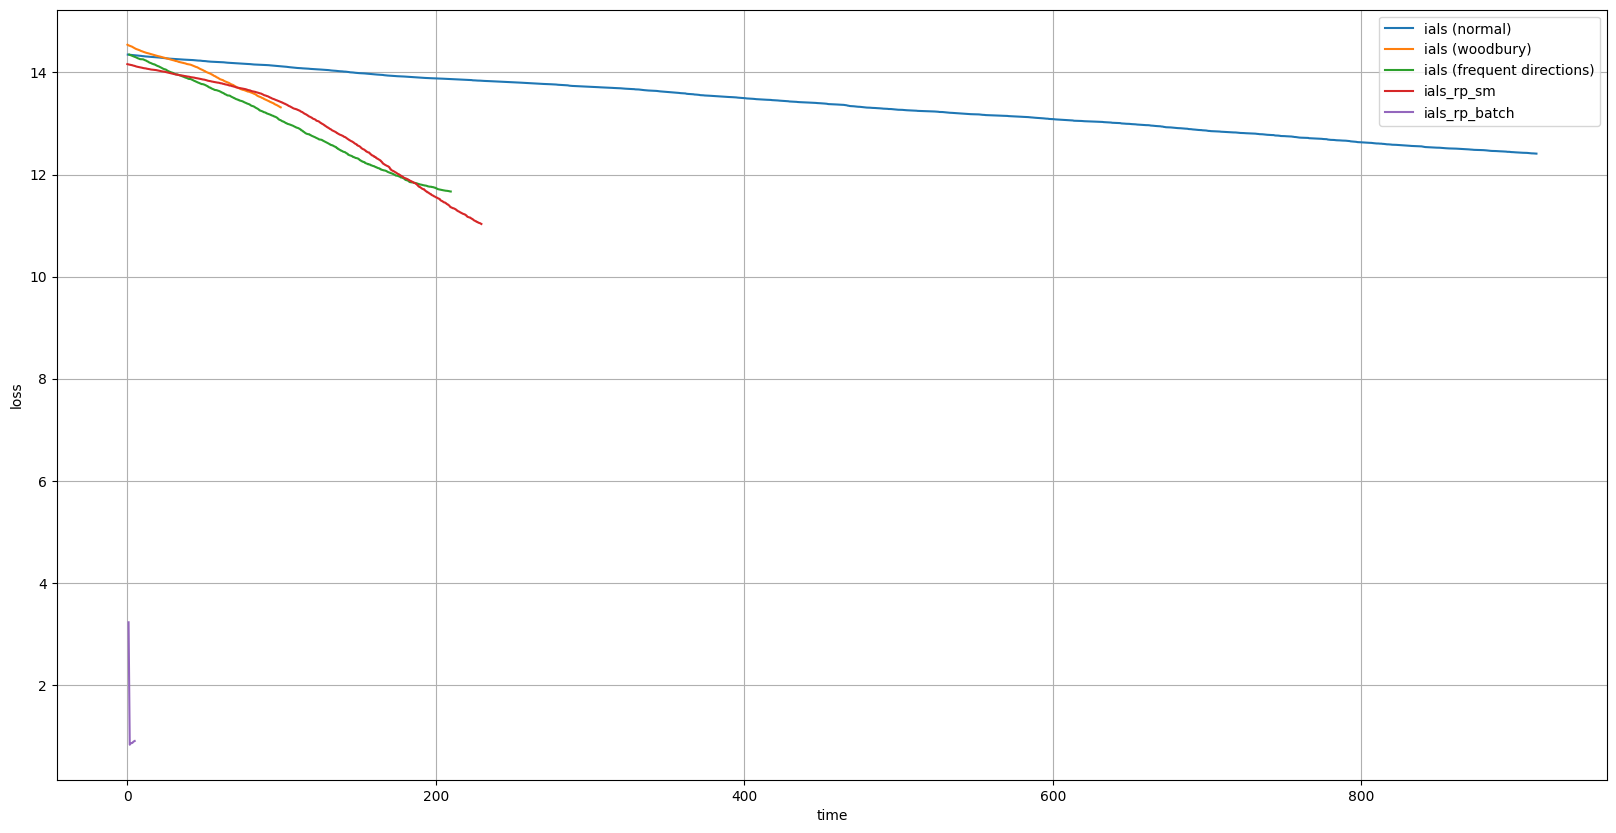

In [74]:
plt.figure(figsize = (20, 10))
plt.grid()
plt.plot(times_ials, losses_ials, label = "ials (normal)")
plt.plot(times_ials_lr, losses_ials_lr, label = "ials (woodbury)")
plt.plot(times_fd, losses_fd, label = "ials (frequent directions)")
plt.plot(times_rp_sm, losses_rp_sm, label = "ials_rp_sm")
plt.plot(times_rp_batch, losses_rp_batch, label = "ials_rp_batch")
plt.ylabel('loss')
plt.xlabel('time')
plt.legend()
plt.show()

# MovieLens 10M

In [75]:
!wget https://files.grouplens.org/datasets/movielens/ml-10m.zip
!unzip ml-10m.zip


--2025-12-24 23:37:54--  https://files.grouplens.org/datasets/movielens/ml-10m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.96.204
Connecting to files.grouplens.org (files.grouplens.org)|128.101.96.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65566137 (63M) [application/zip]
Saving to: ‘ml-10m.zip’

ml-10m.zip          100%[===================>]  62.53M   121KB/s    in 5m 22s  

2025-12-24 23:43:18 (199 KB/s) - ‘ml-10m.zip’ saved [65566137/65566137]

Archive:  ml-10m.zip
   creating: ml-10M100K
  inflating: ml-10M100K/allbut.pl    
  inflating: ml-10M100K/movies.dat   
  inflating: ml-10M100K/ratings.dat  
  inflating: ml-10M100K/README.html  
  inflating: ml-10M100K/split_ratings.sh  
  inflating: ml-10M100K/tags.dat     


In [77]:
import pandas as pd

data = pd.read_csv(
    "ml-10M100K/ratings.dat",
    sep="::",
    engine="python",
    names=["userid", "movieid", "rating", "timestamp"]
)

print(data.shape)
data.head()


(10000054, 4)


,userid,movieid,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


In [78]:
rename_map = {}
if "userid" in data.columns: rename_map["userid"] = "userid"
if "movieid" in data.columns: rename_map["movieid"] = "movieid"
ratings = data.rename(columns=rename_map)

required = {"userid", "movieid", "rating", "timestamp"}
missing = required - set(ratings.columns)
if missing:
    raise ValueError(f"MovieLens dataframe missing required columns: {missing}. Columns: {ratings.columns.tolist()}")

ratings["userid"] = pd.to_numeric(ratings["userid"], errors="raise").astype(np.int64)
ratings["movieid"] = pd.to_numeric(ratings["movieid"], errors="raise").astype(np.int64)
ratings["timestamp"] = pd.to_numeric(ratings["timestamp"], errors="raise").astype(np.int64)
ratings["rating"] = pd.to_numeric(ratings["rating"], errors="raise").astype(np.float32)

print("Loaded:", ratings.shape, "users:", ratings.userid.nunique(), "items:", ratings.movieid.nunique())

Loaded: (10000054, 4) users: 69878 items: 10677


In [ ]:
train, test, holdout = timepoint_split(ratings, time_split_q=0.95)

print("Rows:", {"train": len(train), "test": len(test), "holdout": len(holdout)})
print("Users:", {"train": train.userid.nunique(), "test": test.userid.nunique(), "holdout": holdout.userid.nunique()})
print("Items:", {"train": train.movieid.nunique(), "test": test.movieid.nunique(), "holdout": holdout.movieid.nunique()})
train_items = set(train.movieid.unique())

train_users = train.userid.unique()
train_items_arr = train.movieid.unique()

user2row = {u: i for i, u in enumerate(train_users)}
item2col = {m: j for j, m in enumerate(train_items_arr)}

train_rows = train.userid.map(user2row).to_numpy()
train_cols = train.movieid.map(item2col).to_numpy()
train_vals = train.rating.to_numpy(dtype=np.float32)

R_train_10M = csr_matrix(
    (train_vals, (train_rows, train_cols)),
    shape=(len(train_users), len(train_items_arr)),
    dtype=np.float32
)

print("R_train:", R_train_10M.shape, "nnz:", R_train_10M.nnz)


Rows: {'train': 8286928, 'test': 899194, 'holdout': 1808}
Users: {'train': 64680, 'test': 1808, 'holdout': 1808}
Items: {'train': 9857, 'test': 9672, 'holdout': 863}
R_train: (64680, 9857) nnz: 8286928


In [80]:
# ials
np.random.seed(42)
config_ials = {'rank': 122, 'iters': 1812, 'l2': 0.2538981330307094, 'weight_kind': 'log1p'}
P_ials, Q_ials, losses_ials, times_ials = iALS(R_train_10M, config_ials['rank'], iters=config_ials['iters'], weight_f = lambda x: np.log(1 + x), l2 = 10)

metrics_ials, topk_items, test_user_ids = run_eval_timepoint_warmstart(train=train,
        test=test,
        holdout=holdout,
        Q=Q_ials,
        item2col=item2col,
        l2=config_ials['l2'],
        alpha=40.0,   
        weight_f=lambda x: np.log(1 + x),
        k=10,
    )
print(metrics_ials)

  0%|          | 0/1812 [00:20<?, ?it/s]


KeyboardInterrupt: 

In [81]:
#ials_LR

np.random.seed(42)
config_ials_lr = {'rank': 64, 
                  'iters': 1127, 
                  'l2': 0.1, 
                  'weight_kind': 'log1p'}

P_ials_lr, Q_ials_lr, losses_ials_lr, times_ials_lr = iALS_LR(R_train_10M, config_ials_lr['rank'], iters=config_ials_lr['iters'], weight_f =lambda x: np.log(1 + x), l2=config_ials_lr['l2'])
metrics_ials_LR, topk_items, test_user_ids = run_eval_timepoint_warmstart(train=train,
        test=test,
        holdout=holdout,
        Q=Q_ials_lr,
        item2col=item2col,
        l2=config_ials_lr['l2'],
        weight_f=lambda x: np.log(1 + x),
        k=10,
    )
print(metrics_ials_LR)

100%|██████████| 1127/1127 [1:00:23<00:00,  3.22s/it]


{'HR@10': 0.00497787610619469, 'MRR@10': 0.0022606756538152695}


In [82]:
#ials_pcg
np.random.seed(42)

config_ials_pcg = {'rank': 123, 
                   'iters': 2416, 
                   'l2': 84.93676871612902, 
                   'ell_mult': 1, 
                   'precond_refresh': 97, 
                   'tol': 1.4059683501670634e-06, 
                   'cg_maxiter': 63, 
                   'weight_kind': 'linear_alpha', 
                   'alpha': 1.1664742590050132}
P_pcg, Q_pcg, losses_fd, times_fd = iALS_pcg_fd(R_train_10M, rank=config_ials_pcg['rank'], weight_f=lambda x, a=config_ials_pcg['alpha']: a * x, iters=config_ials_pcg['iters'], 
                                                l2=config_ials_pcg['l2'], 
                                                ell_mult=config_ials_pcg['ell_mult'], 
                                                precond_refresh=config_ials_pcg['precond_refresh'], 
                                                tol=config_ials_pcg['tol'], 
                                                cg_maxiter=config_ials_pcg['cg_maxiter'])
metrics_pcg, topk_items, test_user_ids = run_eval_timepoint_warmstart(train=train,
        test=test,
        holdout=holdout,
        Q=Q_pcg,
        item2col=item2col,
        l2=config_ials_pcg['l2'], 
        weight_f=lambda x, a=config_ials_pcg['alpha']: a * x,
        k=10,
    )
print(metrics_pcg)

100%|██████████| 2416/2416 [1:46:36<00:00,  2.65s/it]  


{'HR@10': 0.012168141592920354, 'MRR@10': 0.005567846354097128}


In [83]:
#ials_rp_batch
np.random.seed(42)

config_ials_rp_batch = {'rank': 32, 
                        'epochs': 6, 
                        'l2': 10.0, 
                        'proj_dim_ratio': 0.5549816829830596, 
                        'use_preconditioner': False, 
                        'weight_kind': 'log1p'}


P_rp_batch, Q_rp_batch, losses_rp_batch, times_rp_batch = iALS_RP_batch(
        R_train_10M, rank=config_ials_rp_batch['rank'], weight_f=lambda x: np.log1p(x),
        epochs=config_ials_rp_batch['epochs'], l2=config_ials_rp_batch['l2'], proj_dim_ratio=config_ials_rp_batch['proj_dim_ratio']
)
metrics_rp_batch, topk_items, test_user_ids = run_eval_timepoint_warmstart(train=train,
        test=test,
        holdout=holdout,
        Q=Q_rp_batch,
        item2col=item2col,
        l2=config_ials_rp_batch['l2'], 
        weight_f=lambda x: np.log1p(x),
        k=10,
    )
print(metrics_rp_sm)

100%|██████████| 6/6 [00:31<00:00,  5.26s/it]


{'HR@10': 0.028678304239401497, 'MRR@10': 0.008919665589928627}


In [84]:
#ials_rp_sm

np.random.seed(42)

config_rp_sm = {'rank': 128, 
                'iters': 2016, 
                'l2': 10.0, 
                'proj_dim_ratio': 0.3097128253270056, 
                'use_projection_every': 8, 
                'weight_kind': 'log1p'}

P_rp_sm, Q_rp_sm, losses_rp_sm, times_rp_sm = iALS_RP_SM(
    R_train_10M, rank=config_rp_sm['rank'], weight_f=lambda x: np.log1p(x),
    iters=config_rp_sm['iters'], l2=config_rp_sm['l2'], proj_dim_ratio=config_rp_sm['proj_dim_ratio'], use_projection_every=config_rp_sm['use_projection_every']
)
metrics_rp_sm, topk_items, test_user_ids = run_eval_timepoint_warmstart(train=train,
        test=test,
        holdout=holdout,
        Q=Q_rp_sm,
        item2col=item2col,
        l2=config_rp_sm['l2'], 
        weight_f= lambda x: np.log(1 + x),
        k=10,
    )
print(metrics_rp_sm)

100%|██████████| 2016/2016 [1:25:58<00:00,  2.56s/it]


{'HR@10': 0.004424778761061947, 'MRR@10': 0.0009832842042669654}


In [85]:
import pandas as pd

results = pd.DataFrame([metrics_ials, metrics_ials_LR, metrics_pcg, metrics_rp_sm, metrics_rp_batch])
results['model'] = ['ials', 'ials_LR', 'ials_pcg', 'ials_rp_sm', 'ials_batch']
results

,HR@10,MRR@10,model
0,0.034913,0.014025,ials
1,0.004978,0.002261,ials_LR
2,0.012168,0.005568,ials_pcg
3,0.004425,0.000983,ials_rp_sm
4,0.013827,0.005264,ials_batch


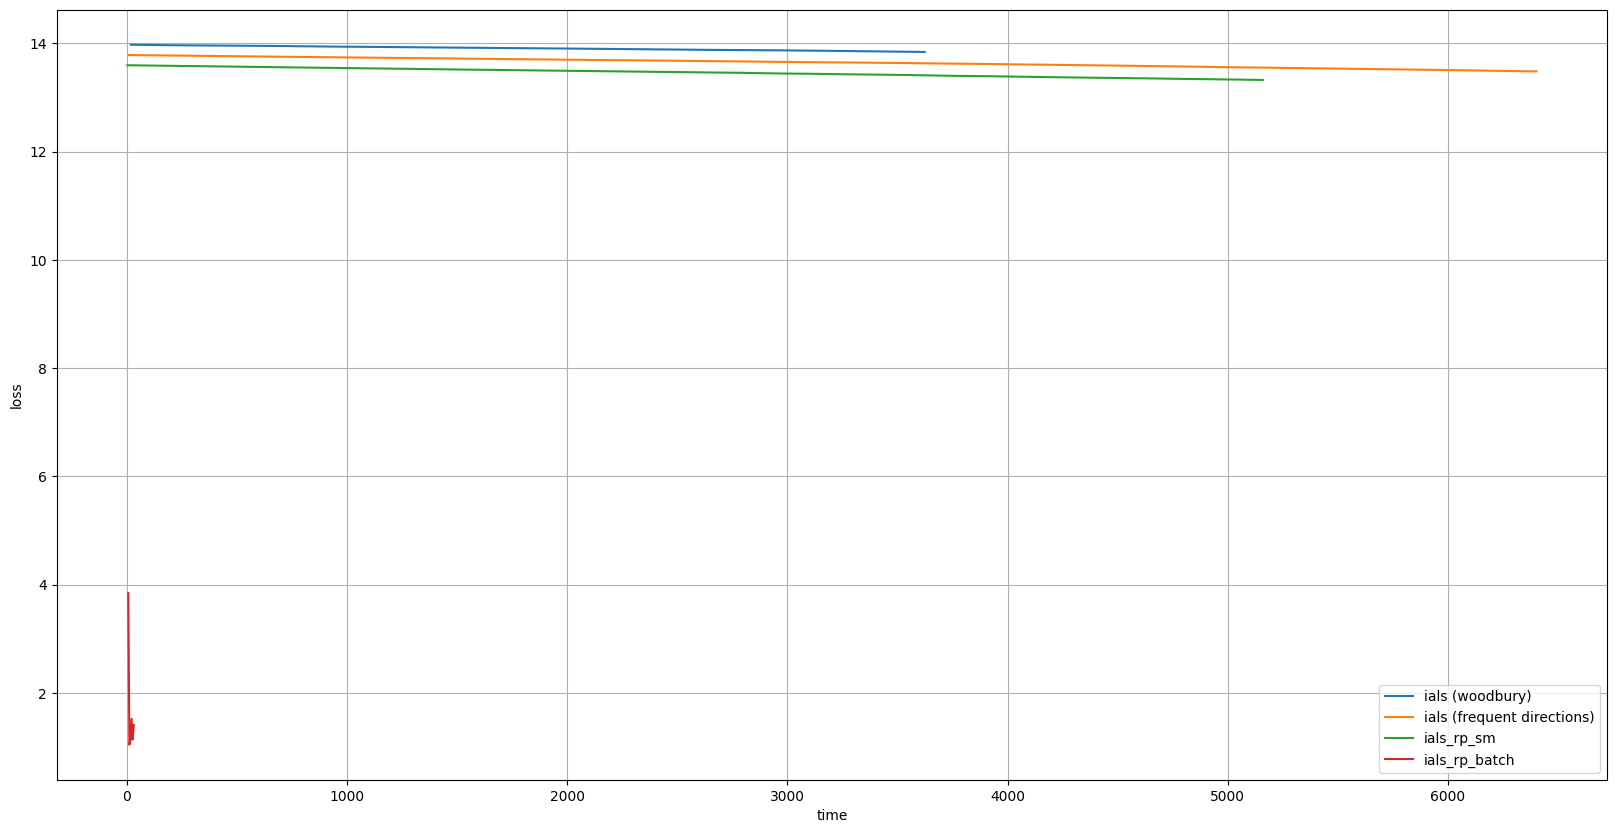

In [87]:
plt.figure(figsize = (20, 10))
plt.grid()
# plt.plot(times_ials, losses_ials, label = "ials (normal)")
plt.plot(times_ials_lr, losses_ials_lr, label = "ials (woodbury)")
plt.plot(times_fd, losses_fd, label = "ials (frequent directions)")
plt.plot(times_rp_sm, losses_rp_sm, label = "ials_rp_sm")
plt.plot(times_rp_batch, losses_rp_batch, label = "ials_rp_batch")
plt.ylabel('loss')
plt.xlabel('time')
plt.legend()
plt.show()

In [88]:
import pandas as pd

results = pd.DataFrame([metrics_ials_LR, metrics_pcg, metrics_rp_sm, metrics_rp_batch])
results['model'] = ['ials_LR', 'ials_pcg', 'ials_rp_sm', 'ials_batch']
results

,HR@10,MRR@10,model
0,0.004978,0.002261,ials_LR
1,0.012168,0.005568,ials_pcg
2,0.004425,0.000983,ials_rp_sm
3,0.013827,0.005264,ials_batch


## Рандом

In [ ]:

data_description = {
    'users': 'userid',
    'items': 'movieid',
    'test_users': holdout['userid'].unique()
}


In [40]:
def build_random_model(config: dict, trainset: pd.DataFrame, trainset_description: dict):
    itemid = trainset_description['items']
    n_items = trainset[itemid].nunique()
    random_state = np.random.default_rng(config.get('seed', None))
    return n_items, random_state


def random_model_scoring(params: tuple, testset: pd.DataFrame, testset_description: dict):
    n_items, random_state = params
    n_users = len(testset_description['test_users'])
    scores = random_state.random((n_users, n_items))
    return scores


def topidx(a: np.ndarray, topn: int):
    parted = np.argpartition(a, -topn)[-topn:]
    return parted[np.argsort(-a[parted])]


def simple_model_recom_func(scores: np.ndarray, topn: int = 10):
    recommendations = np.apply_along_axis(topidx, 1, scores, topn)
    return recommendations

rnd_params = build_random_model(
    {'seed': 99},
    train,
    data_description
)

rnd_scores = random_model_scoring(
    rnd_params,
    None,
    data_description
)

rnd_recoms = simple_model_recom_func(rnd_scores, topn=10)


In [52]:
item_col = data_description['items']
items = train[item_col].unique()
idx2item = dict(enumerate(items))
rnd_recom_items = np.vectorize(idx2item.get)(rnd_recoms)
holdout_sorted = holdout.sort_values('userid')
true_items = holdout_sorted['movieid'].to_numpy()

rnd_metrics = evaluate_recs(rnd_recom_items, true_items, 10)
print(rnd_metrics)


{'HR@10': 0.0012468827930174563, 'MRR@10': 0.00020781380590051413}
